In [0]:
from google.colab import drive
drive.mount('/content/drive')




Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from matplotlib import pyplot as plt

import copy

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


0it [00:00, ?it/s]

100%|█████████▉| 170205184/170498071 [00:11<00:00, 18079724.78it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [0]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False)


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

foreground_classes = {'horse','ship', 'truck'}

background_classes = {'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog'}

# print(type(foreground_classes))

In [6]:
dataiter = iter(trainloader)
background_data=[]
background_label=[]
foreground_data=[]
foreground_label=[]
batch_size=10

for i in range(5000):
  images, labels = dataiter.next()
  for j in range(batch_size):
    if(classes[labels[j]] in background_classes):
      img = images[j].tolist()
      background_data.append(img)
      background_label.append(labels[j])
    else:
      img = images[j].tolist()
      foreground_data.append(img)
      foreground_label.append(labels[j])
            
foreground_data = torch.tensor(foreground_data)
foreground_label = torch.tensor(foreground_label)
background_data = torch.tensor(background_data)
background_label = torch.tensor(background_label)
    

170500096it [00:30, 18079724.78it/s]                               

In [0]:
def imshow(img):
  img = img / 2 + 0.5     # unnormalize
  npimg = img#.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

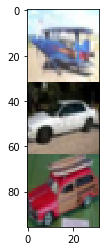

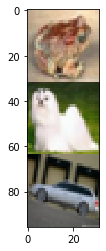

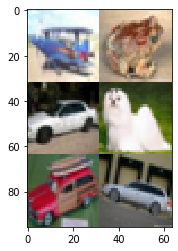

torch.Size([3, 96, 32])


In [8]:
img1 = torch.cat((background_data[0],background_data[1],background_data[2]),1)
imshow(img1)
img2 = torch.cat((background_data[27],background_data[3],background_data[43]),1)
imshow(img2)
img3 = torch.cat((img1,img2),2)
imshow(img3)
print(img2.size())


In [0]:
def create_mosaic_img(bg_idx,fg_idx,fg): 
  """
  bg_idx : list of indexes of background_data[] to be used as background images in mosaic
  fg_idx : index of image to be used as foreground image from foreground data
  fg : at what position/index foreground image has to be stored out of 0-8
  """
  image_list=[]
  j=0
  for i in range(9):
    if i != fg:
      image_list.append(background_data[bg_idx[j]].type("torch.DoubleTensor"))
      j+=1
    else: 
      image_list.append(foreground_data[fg_idx].type("torch.DoubleTensor"))
      label = foreground_label[fg_idx]-7  # minus 7 because our fore ground classes are 7,8,9 but we have to store it as 0,1,2
  #image_list = np.concatenate(image_list ,axis=0)
  image_list = torch.stack(image_list) 
  return image_list,label

In [0]:
desired_num = 30000
mosaic_list_of_images =[]      # list of mosaic images, each mosaic image is saved as list of 9 images
fore_idx =[]                   # list of indexes at which foreground image is present in a mosaic image i.e from 0 to 9               
mosaic_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(desired_num):
  bg_idx = np.random.randint(0,35000,8)
  fg_idx = np.random.randint(0,15000)
  fg = np.random.randint(0,9)
  fore_idx.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  mosaic_list_of_images.append(image_list)
  mosaic_label.append(label)



6


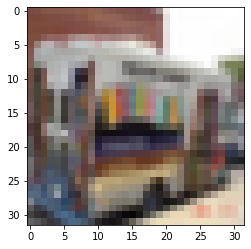

truck


In [11]:
qw=45

print(fore_idx[qw])
imshow(mosaic_list_of_images[qw][fore_idx[qw]])
# print(mosaic_list_of_images[0])
print(classes[mosaic_label[qw]+7]) # add 7 as we had subtracted 7 while saving

# imshow(mosaic_list_of_images[13][2])
# print(type(mosaic_list_of_images[1][0]))
# print(mosaic_label)

In [0]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label, fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    self.fore_idx = fore_idx

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]

batch = 250
msd = MosaicDataset(mosaic_list_of_images, mosaic_label , fore_idx)
train_loader = DataLoader( msd,batch_size= batch ,shuffle=True)

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Module1(nn.Module):
  def __init__(self):
    super(Module1, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    self.fc4 = nn.Linear(10,1)

  def forward(self, z):
    x = torch.zeros([batch,9],dtype=torch.float64)
    y = torch.zeros([batch,3, 32,32], dtype=torch.float64)
    x,y = x.to("cuda"),y.to("cuda")
    for i in range(9):
      x[:,i] = self.helper(z[:,i])[:,0]
    x = F.softmax(x,dim=1)   # alphas
    
    x1 = x[:,0]
    torch.mul(x1[:,None,None,None],z[:,0])

    for i in range(9):            
      x1 = x[:,i]          
      y = y + torch.mul(x1[:,None,None,None],z[:,i])
    return y , x 
  
  def helper(self,x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return x
      


In [0]:
 class Module2(nn.Module):
  def __init__(self):
    super(Module2, self).__init__()
    
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    self.fc4 = nn.Linear(10,3)

  def forward(self,y):  #z batch of list of 9 images
    y1 = self.pool(F.relu(self.conv1(y)))
    y1 = self.pool(F.relu(self.conv2(y1)))
    y1 = y1.view(-1, 16 * 5 * 5)

    y1 = F.relu(self.fc1(y1))
    y1 = F.relu(self.fc2(y1))
    y1 = F.relu(self.fc3(y1))
    y1 = self.fc4(y1)
    return y1 


In [0]:
where_net = Module1().double()
where_net = where_net.to("cuda")
# print(net.parameters)

In [0]:
# idx = np.random.randint(0,250,10)
# train_iter = iter(train_loader)
# images,labels,_=train_iter.next()

# for i in idx:
#   imshow(where_net1(images)[i].detach().numpy())

In [0]:
what_net = Module2().double()
what_net = what_net.to("cuda")

In [0]:
# where_net.load_state_dict(torch.load("model_epoch90.pt"))
# what_net.load_state_dict(torch.load("model_epoch90.pt"))
# print(fore_net.parameters)

In [0]:
test_images =[]        #list of mosaic images, each mosaic image is saved as laist of 9 images
fore_idx_test =[]                   #list of indexes at which foreground image is present in a mosaic image                
test_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(10000):
  bg_idx = np.random.randint(0,35000,8)
  fg_idx = np.random.randint(0,15000)
  fg = np.random.randint(0,9)
  fore_idx_test.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  test_images.append(image_list)
  test_label.append(label)

In [0]:
test_data = MosaicDataset(test_images,test_label,fore_idx_test)
test_loader = DataLoader( test_data,batch_size= batch ,shuffle=False)

In [21]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer_where = optim.SGD(where_net.parameters(), lr=0.01, momentum=0.9)
optimizer_what = optim.SGD(what_net.parameters(), lr=0.01, momentum=0.9)

nos_epochs = 220
every_what_epoch = 10
#---------------------------------------------
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0
argmax_more_than_half = 0
argmax_less_than_half =0
col1=[]
col2=[]
col3=[]
col4=[]
col5=[]
col6=[]
col7=[]
col8=[]
col9=[]
col10=[]
col11=[]
col12=[]
col13=[]
#-----------------------------------------------
train_loss=[]
test_loss =[]
train_acc = []
test_acc = []
for epoch in range(nos_epochs):  # loop over the dataset multiple times
    
  focus_true_pred_true =0
  focus_false_pred_true =0
  focus_true_pred_false =0
  focus_false_pred_false =0
  argmax_more_than_half = 0
  argmax_less_than_half =0
  
  running_loss = 0.0
  batch_correct = 0.0
  cnt=0
  total=0
  iteration = desired_num // batch



  #training data set

  if (epoch % (every_what_epoch*2) ) < every_what_epoch :
    print(epoch,"updating where_net, what_net is freezed") 
  elif (epoch % (every_what_epoch*2)) > every_what_epoch :
    print(epoch,"updating what_net, where_net is freezed")
      
    
  for i, data in  enumerate(train_loader):
      inputs , labels , fore_idx = data
      inputs,labels = inputs.to("cuda"),labels.to("cuda") 
      # zero the parameter gradients
      
      optimizer_what.zero_grad()
      optimizer_where.zero_grad()
      
      avg_images , alphas = where_net(inputs)
      outputs = what_net(avg_images)
      
      _, predicted = torch.max(outputs.data, 1)
      

      loss = criterion(outputs, labels) 
      loss.backward() 
  
      if (epoch % (every_what_epoch*2) ) < every_what_epoch :
        optimizer_where.step()
          
      elif (epoch % (every_what_epoch*2)) > every_what_epoch :
        optimizer_what.step()
          
      batch_correct += sum(predicted == labels)
      total += len(predicted)
      running_loss += loss.item()
      if cnt % 120 == 119:    # print every 40 mini-batches
          print("--"*40)
          print("Epoch: ",epoch)
#             print('[%d, %5d] loss: %.3f' %(epoch + 1, cnt + 1, running_loss / 120))
          train_loss.append(running_loss/120)
          train_acc.append(batch_correct.item()/desired_num)
          print("total_Correct:",batch_correct.item(),"Total:",total,"train_loss",running_loss/120,"train_acc: ", batch_correct.item()/total)
          #running_loss = 0.0
      cnt=cnt+1

      if epoch % 5 == 0:
        for j in range (batch):
          focus = torch.argmax(alphas[j])

          if(alphas[j][focus] >= 0.5):
            argmax_more_than_half +=1
          else:
            argmax_less_than_half +=1

          if(focus == fore_idx[j] and predicted[j] == labels[j]):
            focus_true_pred_true += 1

          elif(focus != fore_idx[j] and predicted[j] == labels[j]):
            focus_false_pred_true +=1

          elif(focus == fore_idx[j] and predicted[j] != labels[j]):
            focus_true_pred_false +=1

          elif(focus != fore_idx[j] and predicted[j] != labels[j]):
            focus_false_pred_false +=1

  if epoch % 5 == 0:
    col1.append(epoch)
    col2.append(argmax_more_than_half)
    col3.append(argmax_less_than_half)
    col4.append(focus_true_pred_true)
    col5.append(focus_false_pred_true)
    col6.append(focus_true_pred_false)
    col7.append(focus_false_pred_false)
  
    with torch.no_grad():
      loss = 0.0
      correct = 0.0
      tot =0
      focus_true_pred_true =0
      focus_false_pred_true =0
      focus_true_pred_false =0
      focus_false_pred_false =0
      argmax_more_than_half = 0
      argmax_less_than_half =0

      for data in test_loader:
        inputs, labels , fore_idx = data
        inputs,labels = inputs.to("cuda"),labels.to("cuda") 
        avg_images , alphas = where_net(inputs)
        outputs = what_net(avg_images)
        _, predicted = torch.max(outputs.data, 1)
        loss += criterion(outputs, labels).item() 
        correct += sum(predicted == labels)
        tot += len(predicted)

        for j in range (batch):
          focus = torch.argmax(alphas[j])

          if(alphas[j][focus] >= 0.5):
            argmax_more_than_half +=1
          else:
            argmax_less_than_half +=1

          if(focus == fore_idx[j] and predicted[j] == labels[j]):
            focus_true_pred_true += 1

          elif(focus != fore_idx[j] and predicted[j] == labels[j]):
            focus_false_pred_true +=1

          elif(focus == fore_idx[j] and predicted[j] != labels[j]):
            focus_true_pred_false +=1

          elif(focus != fore_idx[j] and predicted[j] != labels[j]):
            focus_false_pred_false +=1
          
      test_loss.append(loss/40) # 10000/250 = 40
      test_acc.append(correct.item()/tot)
      print("total_Correct:",correct.item(),"Total:",tot,"test loss: ", loss/40, "test accuracy", correct.item()/tot)

    col8.append(argmax_more_than_half)
    col9.append(argmax_less_than_half)
    col10.append(focus_true_pred_true)
    col11.append(focus_false_pred_true)
    col12.append(focus_true_pred_false)
    col13.append(focus_false_pred_false)

  elif epoch % 5 != 0  :
    with torch.no_grad():
      loss = 0.0
      correct = 0.0
      tot =0
      for data in test_loader:
        inputs, labels , fore_idx = data
        inputs,labels = inputs.to("cuda"),labels.to("cuda") 
        avg_images , alphas = where_net(inputs)
        outputs = what_net(avg_images)
        _, predicted = torch.max(outputs.data, 1)
        loss += criterion(outputs, labels).item() 
        correct += sum(predicted == labels)
        tot += len(predicted)

      test_loss.append(loss/40) # 10000/250 = 40
      test_acc.append(correct.item()/tot)
      print("total_Correct:",correct.item(),"Total:",tot,"test loss: ", loss/40, "test accuracy", correct.item()/tot)
 
    
  if (epoch % (every_what_epoch*2) == every_what_epoch*2 - 1):
      torch.save(where_net.state_dict(),"/content/drive/My Drive/Research/stage_wise_training/where_what/alternate_training_220_every10epochs_lr_01_focus_vs_pred/where_model_at_epoch"+str(epoch)+".pt")
      torch.save(what_net.state_dict(),"/content/drive/My Drive/Research/stage_wise_training/where_what/alternate_training_220_every10epochs_lr_01_focus_vs_pred/what_model_at_epoch"+str(epoch)+".pt")
    
print('Finished Training')
torch.save(where_net.state_dict(),"/content/drive/My Drive/Research/stage_wise_training/where_what/alternate_training_220_every10epochs_lr_01_focus_vs_pred/full_where_model_epoch"+str(nos_epochs)+".pt")
torch.save(what_net.state_dict(),"/content/drive/My Drive/Research/stage_wise_training/where_what/alternate_training_220_every10epochs_lr_01_focus_vs_pred/full_what_model_epoch"+str(nos_epochs)+".pt")

0 updating where_net, what_net is freezed
--------------------------------------------------------------------------------
Epoch:  0
total_Correct: 10021.0 Total: 30000 train_loss 1.0991898327500607 train_acc:  0.33403333333333335
total_Correct: 3297.0 Total: 10000 test loss:  1.099277804427109 test accuracy 0.3297
1 updating where_net, what_net is freezed
--------------------------------------------------------------------------------
Epoch:  1
total_Correct: 10021.0 Total: 30000 train_loss 1.0991898326825895 train_acc:  0.33403333333333335
total_Correct: 3297.0 Total: 10000 test loss:  1.0992778043829685 test accuracy 0.3297
2 updating where_net, what_net is freezed
--------------------------------------------------------------------------------
Epoch:  2
total_Correct: 10021.0 Total: 30000 train_loss 1.0991898326244558 train_acc:  0.33403333333333335
total_Correct: 3297.0 Total: 10000 test loss:  1.099277804330073 test accuracy 0.3297
3 updating where_net, what_net is freezed
------

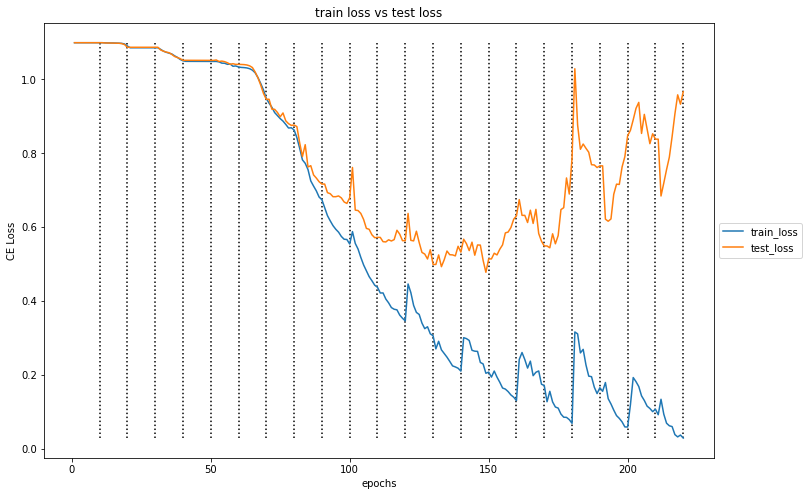

In [22]:
fig = plt.figure(figsize = (12,8) )
vline_list = np.arange(every_what_epoch, nos_epochs + every_what_epoch, every_what_epoch )
# train_loss = np.random.randn(340)
# test_loss = np.random.randn(340)
epoch_list = np.arange(1, nos_epochs+1)
plt.plot(epoch_list,train_loss, label='train_loss')
plt.plot(epoch_list,test_loss, label='test_loss')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("CE Loss")
plt.vlines(vline_list,min(min(train_loss),min(test_loss)), max(max(test_loss),max(train_loss)),linestyles='dotted')
plt.title("train loss vs test loss")
plt.show()
fig.savefig("train_test_loss_plot.pdf")


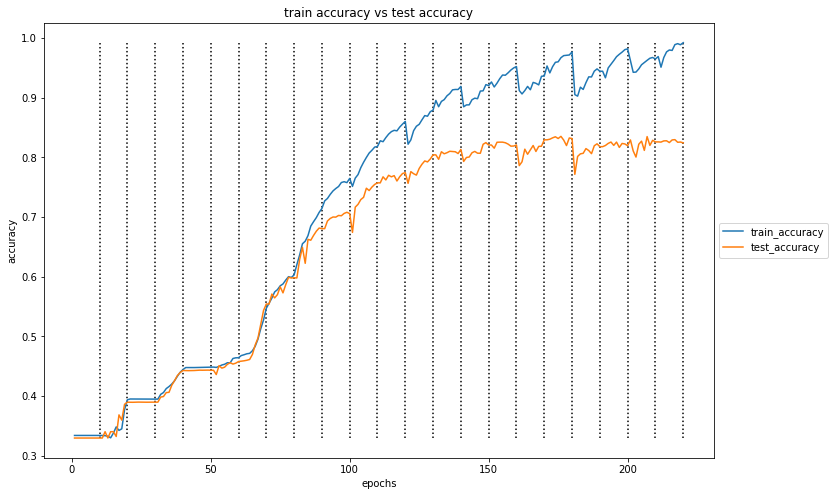

In [23]:
fig = plt.figure(figsize = (12,8) )
vline_list = np.arange(every_what_epoch, nos_epochs + every_what_epoch, every_what_epoch )
# train_acc = np.random.randn(340)
# test_acc = np.random.randn(340)
epoch_list = np.arange(1, nos_epochs+1)
plt.plot(epoch_list,train_acc, label='train_accuracy')
plt.plot(epoch_list,test_acc, label='test_accuracy')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.vlines(vline_list,min(min(train_acc),min(test_acc)), max(max(test_acc),max(train_acc)),linestyles='dotted')
plt.title("train accuracy vs test accuracy")
plt.show()
fig.savefig("train_test_acc_plot.pdf")

In [0]:
columns = ["epochs", "argmax > 0.5" ,"argmax < 0.5", "focus_true_pred_true", "focus_false_pred_true", "focus_true_pred_false", "focus_false_pred_false" ]
df_train = pd.DataFrame()
df_test = pd.DataFrame()
df_train[columns[0]] = col1
df_train[columns[1]] = col2
df_train[columns[2]] = col3
df_train[columns[3]] = col4
df_train[columns[4]] = col5
df_train[columns[5]] = col6
df_train[columns[6]] = col7

df_test[columns[0]] = col1
df_test[columns[1]] = col8
df_test[columns[2]] = col9
df_test[columns[3]] = col10
df_test[columns[4]] = col11
df_test[columns[5]] = col12
df_test[columns[6]] = col13

In [25]:
df_train

epochs  argmax > 0.5  ...  focus_true_pred_false  focus_false_pred_false
0        0             0  ...                   1601                   18378
1        5             0  ...                   1596                   18383
2       10             0  ...                   1595                   18384
3       15             0  ...                   2085                   17464
4       20             0  ...                   1665                   16482
5       25             0  ...                   2089                   16060
6       30             0  ...                   2437                   15716
7       35             0  ...                   2265                   15130
8       40             0  ...                   2241                   14326
9       45             0  ...                   2330                   14228
10      50             0  ...                   2811                   13733
11      55             0  ...                   2675                   13650
12      60             0  ...                   2804                   13160
13      65             0  ...                   2906                   12594
14      70          8839  ...                   3127                   10211
15      75          8839  ...                   2530                    9836
16      80         10166  ...                   2323                    9067
17      85         17263  ...                   2435                    7021
18      90         19463  ...                   2184                    6007
19      95         19463  ...                   1631                    5835
20     100         17177  ...                   1677                    5785
21     105         20525  ...                   1565                    4443
22     110         22041  ...                   1325                    3844
23     115         22041  ...                    963                    3681
24     120         20367  ...                   1095                    4247
25     125         22590  ...                    870                    3247
26     130         24057  ...                    698                    2444
27     135         24057  ...                    547                    2247
28     140         22780  ...                    714                    2747
29     145         23274  ...                    689                    2365
30     150         24319  ...                    465                    1748
31     155         24319  ...                    362                    1513
32     160         22683  ...                    656                    1986
33     165         23132  ...                    539                    1696
34     170         23778  ...                    358                    1051
35     175         23778  ...                    199                     795
36     180         20431  ...                    858                    1991
37     185         21892  ...                    513                    1444
38     190         21352  ...                    497                    1177
39     195         21352  ...                    202                     741
40     200         22176  ...                    338                     797
41     205         22450  ...                    349                     886
42     210         22094  ...                    254                     682
43     215         22094  ...                    167                     461

[44 rows x 7 columns]

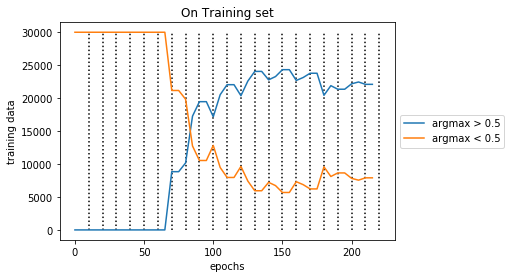

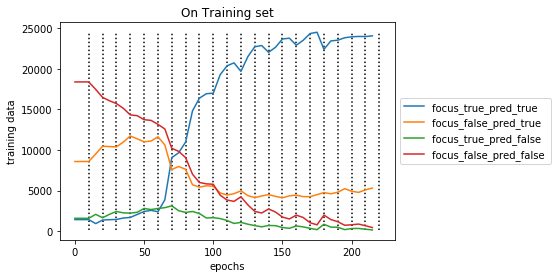

In [26]:
# plt.figure(12,12)
plt.plot(col1,col2, label='argmax > 0.5')
plt.plot(col1,col3, label='argmax < 0.5')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("training data")
plt.title("On Training set")
plt.vlines(vline_list,min(min(col2),min(col3)), max(max(col2),max(col3)),linestyles='dotted')
plt.show()

plt.plot(col1,col4, label ="focus_true_pred_true ")
plt.plot(col1,col5, label ="focus_false_pred_true ")
plt.plot(col1,col6, label ="focus_true_pred_false ")
plt.plot(col1,col7, label ="focus_false_pred_false ")
plt.title("On Training set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("training data")
plt.vlines(vline_list,min(min(col4),min(col5),min(col6),min(col7)), max(max(col4),max(col5),max(col6),max(col7)),linestyles='dotted')
plt.show()

In [27]:
df_test

epochs  argmax > 0.5  ...  focus_true_pred_false  focus_false_pred_false
0        0             0  ...                    566                    6137
1        5             0  ...                    563                    6140
2       10             0  ...                    561                    6142
3       15             0  ...                    564                    6113
4       20             0  ...                    600                    5504
5       25             0  ...                    730                    5373
6       30             0  ...                    814                    5288
7       35             0  ...                    767                    5051
8       40             0  ...                    776                    4797
9       45             0  ...                    827                    4739
10      50             0  ...                    897                    4670
11      55             0  ...                    869                    4599
12      60             0  ...                    915                    4501
13      65             0  ...                    981                    4163
14      70          3005  ...                   1063                    3395
15      75          3005  ...                    855                    3416
16      80          3838  ...                    793                    3228
17      85          5568  ...                    835                    2554
18      90          6414  ...                    777                    2418
19      95          6414  ...                    601                    2373
20     100          5882  ...                    579                    2679
21     105          6856  ...                    664                    1854
22     110          7109  ...                    637                    1791
23     115          7109  ...                    523                    1784
24     120          7110  ...                    501                    1935
25     125          7257  ...                    516                    1600
26     130          7773  ...                    483                    1476
27     135          7773  ...                    461                    1438
28     140          7004  ...                    471                    1598
29     145          7486  ...                    443                    1488
30     150          7735  ...                    447                    1347
31     155          7735  ...                    405                    1351
32     160          6237  ...                    637                    1502
33     165          7456  ...                    489                    1313
34     170          7568  ...                    483                    1224
35     175          7568  ...                    440                    1209
36     180          6404  ...                    572                    1713
37     185          6608  ...                    567                    1319
38     190          6733  ...                    543                    1279
39     195          6733  ...                    466                    1279
40     200          7425  ...                    456                    1253
41     205          6906  ...                    518                    1366
42     210          6928  ...                    501                    1241
43     215          6928  ...                    440                    1269

[44 rows x 7 columns]

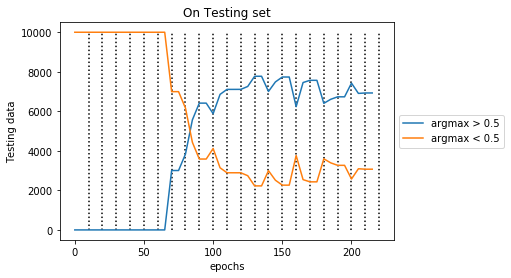

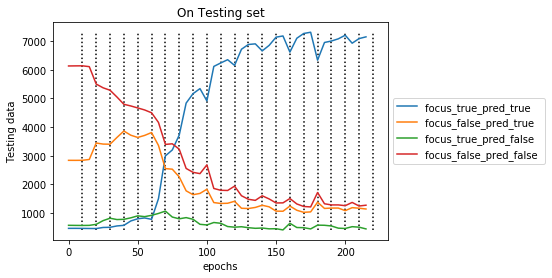

In [28]:
# plt.figure(12,12)
plt.plot(col1,col8, label='argmax > 0.5')
plt.plot(col1,col9, label='argmax < 0.5')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("Testing data")
plt.title("On Testing set")
plt.vlines(vline_list,min(min(col8),min(col9)), max(max(col8),max(col9)),linestyles='dotted')
plt.show()

plt.plot(col1,col10, label ="focus_true_pred_true ")
plt.plot(col1,col11, label ="focus_false_pred_true ")
plt.plot(col1,col12, label ="focus_true_pred_false ")
plt.plot(col1,col13, label ="focus_false_pred_false ")
plt.title("On Testing set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("Testing data")
plt.vlines(vline_list,min(min(col10),min(col11),min(col12),min(col13)), max(max(col10),max(col11),max(col12),max(col13)),linestyles='dotted')
plt.show()

In [29]:
print("-"*20,"Training Dataset","-"*20)
print("epochs", col1) 
print("argmax > 0.5 ", col2) 
print("argmax < 0.5 ", col3) 
print("focus_true_pred_true", col4) 
print("focus_false_pred_true", col5)
print("focus_true_pred_false", col6) 
print("focus_false_pred_false", col7) 
print("-"*20,"Testing Dataset","-"*20)
print("argmax > 0.5 ", col8)
print("argmax < 0.5", col9) 
print("focus_true_pred_true", col10) 
print("focus_false_pred_true", col11)
print("focus_true_pred_false", col12) 
print("focus_false_pred_false", col13) 

-------------------- Training Dataset --------------------
epochs [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215]
argmax > 0.5  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8839, 8839, 10166, 17263, 19463, 19463, 17177, 20525, 22041, 22041, 20367, 22590, 24057, 24057, 22780, 23274, 24319, 24319, 22683, 23132, 23778, 23778, 20431, 21892, 21352, 21352, 22176, 22450, 22094, 22094]
argmax < 0.5  [30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 21161, 21161, 19834, 12737, 10537, 10537, 12823, 9475, 7959, 7959, 9633, 7410, 5943, 5943, 7220, 6726, 5681, 5681, 7317, 6868, 6222, 6222, 9569, 8108, 8648, 8648, 7824, 7550, 7906, 7906]
focus_true_pred_true [1437, 1436, 1434, 944, 1385, 1426, 1456, 1628, 1703, 2064, 2436, 2572, 2410, 3874, 9065, 9662, 10979, 14824, 16379, 16932, 16996, 19275, 20367, 2072

In [0]:
df_train.to_csv("/content/drive/My Drive/Research/stage_wise_training/where_what/alternate_training_220_every10epochs_lr_01_focus_vs_pred/focus_vs_predicted_train.csv")
df_test.to_csv("/content/drive/My Drive/Research/stage_wise_training/where_what/alternate_training_200_every5epochs_lr_01_focus_vs_pred/focus_vs_predicted_test.csv")

In [0]:
def display(img):
  img = img / 2 + 0.5     # unnormalize
  npimg = img
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

****************************************************************************************************


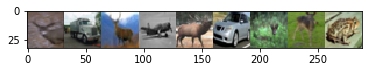

tensor([0.0071, 0.8912, 0.0326, 0.0401, 0.0009, 0.0019, 0.0145, 0.0080, 0.0037],
       device='cuda:0', dtype=torch.float64)


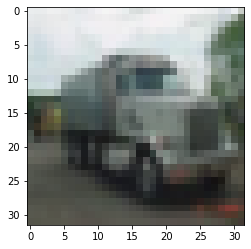

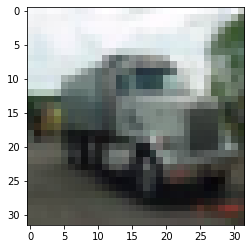

predicted truck
true truck
****************************************************************************************************


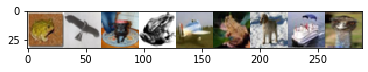

tensor([0.0025, 0.0058, 0.0092, 0.0093, 0.0342, 0.0040, 0.0019, 0.9194, 0.0137],
       device='cuda:0', dtype=torch.float64)


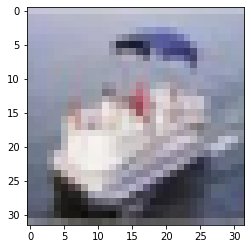

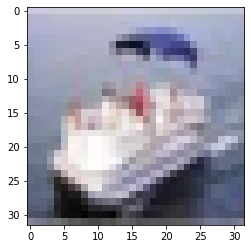

predicted ship
true ship
****************************************************************************************************


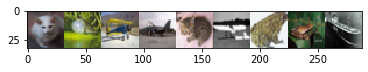

tensor([0.0321, 0.0178, 0.0501, 0.0320, 0.0051, 0.0130, 0.0103, 0.0140, 0.8256],
       device='cuda:0', dtype=torch.float64)


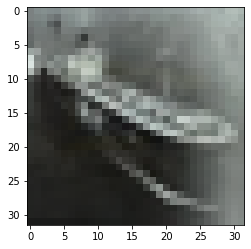

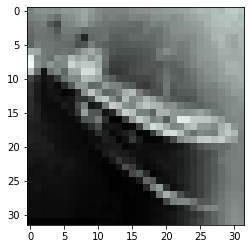

predicted ship
true ship
****************************************************************************************************


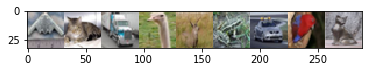

tensor([0.0948, 0.0387, 0.5389, 0.0321, 0.0060, 0.0061, 0.1630, 0.0481, 0.0724],
       device='cuda:0', dtype=torch.float64)


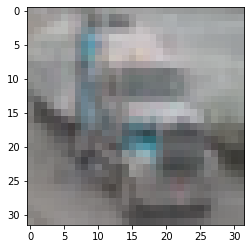

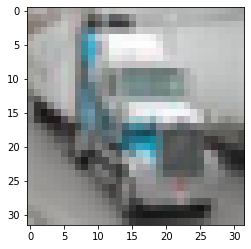

predicted truck
true truck
****************************************************************************************************


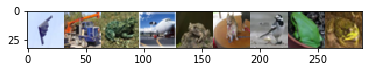

tensor([0.0121, 0.7863, 0.0039, 0.0582, 0.0454, 0.0289, 0.0298, 0.0179, 0.0176],
       device='cuda:0', dtype=torch.float64)


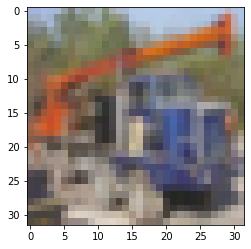

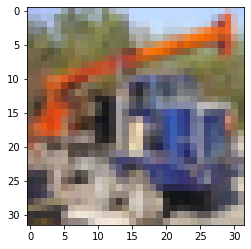

predicted truck
true truck
****************************************************************************************************


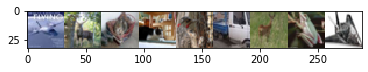

tensor([0.0145, 0.3019, 0.2512, 0.0095, 0.0133, 0.3702, 0.0094, 0.0113, 0.0186],
       device='cuda:0', dtype=torch.float64)


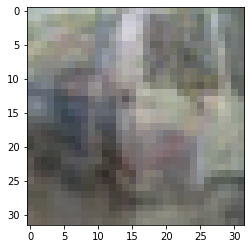

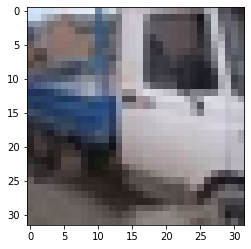

predicted truck
true truck
****************************************************************************************************


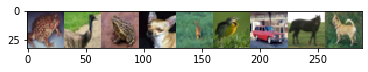

tensor([0.0021, 0.0013, 0.0026, 0.0016, 0.0071, 0.0039, 0.0056, 0.9728, 0.0029],
       device='cuda:0', dtype=torch.float64)


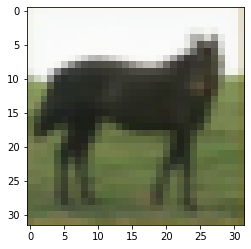

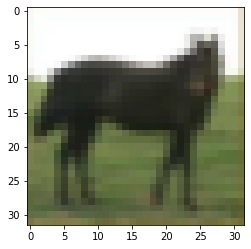

predicted horse
true horse
****************************************************************************************************


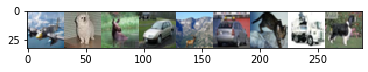

tensor([0.0069, 0.0116, 0.0047, 0.0115, 0.1371, 0.0338, 0.0054, 0.7818, 0.0073],
       device='cuda:0', dtype=torch.float64)


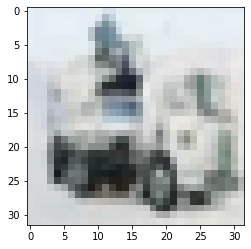

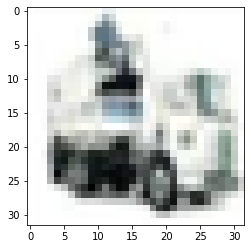

predicted truck
true truck
****************************************************************************************************


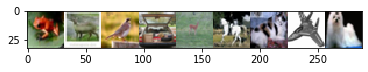

tensor([0.0533, 0.0032, 0.0014, 0.0252, 0.0088, 0.8982, 0.0030, 0.0030, 0.0039],
       device='cuda:0', dtype=torch.float64)


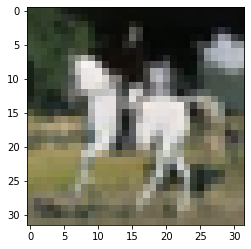

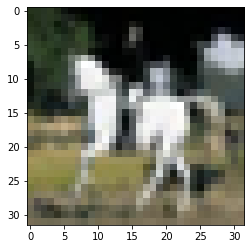

predicted horse
true horse
****************************************************************************************************


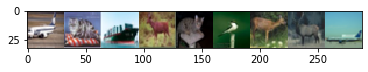

tensor([0.0287, 0.0606, 0.7891, 0.0268, 0.0084, 0.0010, 0.0014, 0.0136, 0.0704],
       device='cuda:0', dtype=torch.float64)


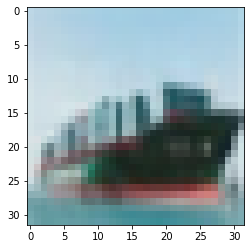

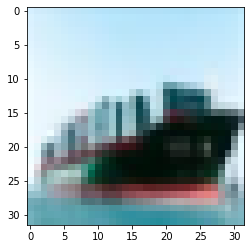

predicted ship
true ship
****************************************************************************************************


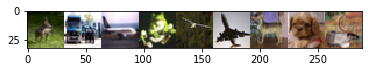

tensor([3.1696e-04, 9.9577e-01, 9.7101e-04, 5.5199e-05, 7.6022e-04, 1.6735e-04,
        7.2804e-04, 9.6733e-04, 2.6449e-04], device='cuda:0',
       dtype=torch.float64)


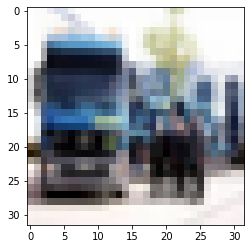

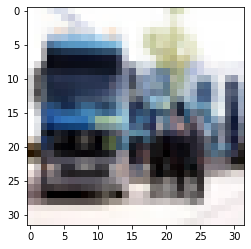

predicted truck
true truck
****************************************************************************************************


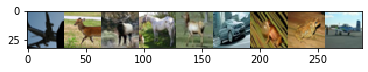

tensor([0.0341, 0.0030, 0.0036, 0.8575, 0.0346, 0.0274, 0.0034, 0.0042, 0.0323],
       device='cuda:0', dtype=torch.float64)


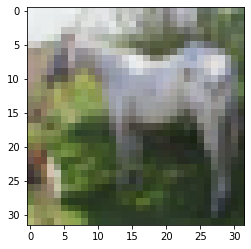

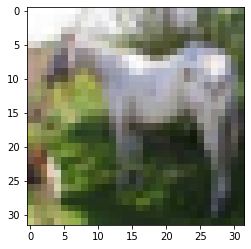

predicted horse
true horse
****************************************************************************************************


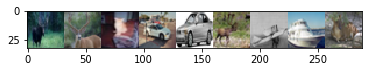

tensor([0.0874, 0.0197, 0.0087, 0.0481, 0.0114, 0.0269, 0.2274, 0.4709, 0.0995],
       device='cuda:0', dtype=torch.float64)


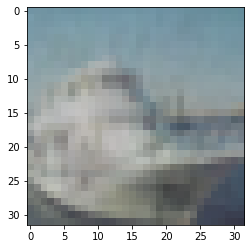

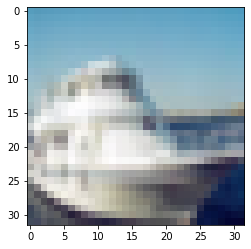

predicted ship
true ship
****************************************************************************************************


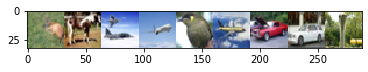

tensor([0.0066, 0.8893, 0.0099, 0.0034, 0.0068, 0.0122, 0.0139, 0.0249, 0.0329],
       device='cuda:0', dtype=torch.float64)


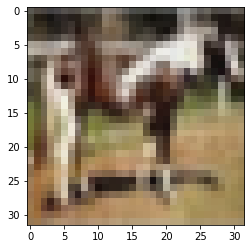

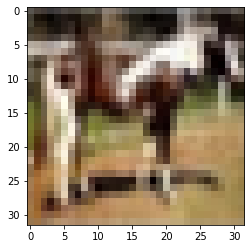

predicted horse
true horse
****************************************************************************************************


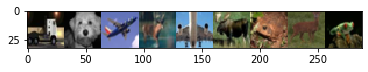

tensor([0.6715, 0.0084, 0.0147, 0.0231, 0.0826, 0.0116, 0.0095, 0.1609, 0.0177],
       device='cuda:0', dtype=torch.float64)


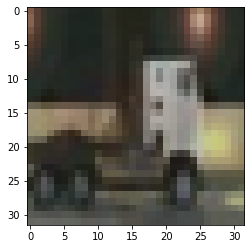

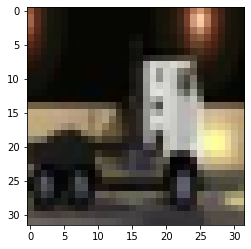

predicted truck
true truck
****************************************************************************************************


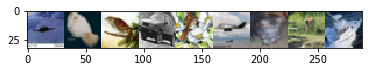

tensor([0.0991, 0.0739, 0.0157, 0.0808, 0.1266, 0.0202, 0.1644, 0.1796, 0.2397],
       device='cuda:0', dtype=torch.float64)


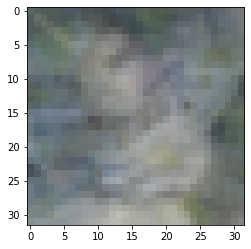

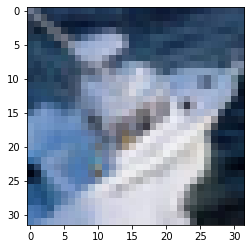

predicted ship
true ship
****************************************************************************************************


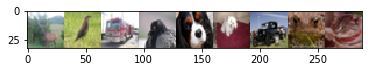

tensor([0.3195, 0.0006, 0.3670, 0.0099, 0.0083, 0.0028, 0.1217, 0.1552, 0.0150],
       device='cuda:0', dtype=torch.float64)


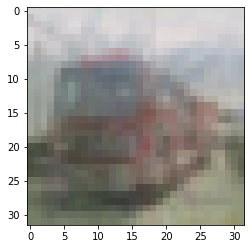

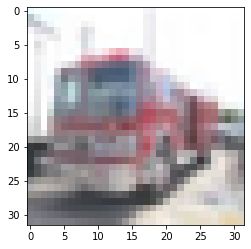

predicted truck
true truck
****************************************************************************************************


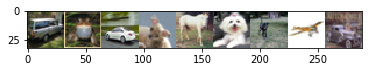

tensor([0.0368, 0.0309, 0.0392, 0.0721, 0.6225, 0.0175, 0.1117, 0.0036, 0.0657],
       device='cuda:0', dtype=torch.float64)


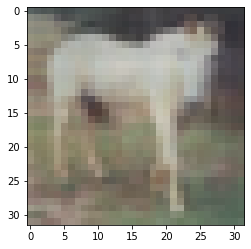

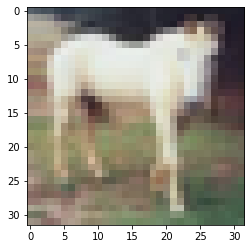

predicted horse
true horse
****************************************************************************************************


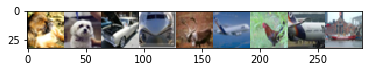

tensor([2.1570e-03, 3.2268e-03, 1.7194e-02, 7.3986e-02, 6.1723e-04, 1.3839e-02,
        2.3947e-03, 1.6374e-02, 8.7021e-01], device='cuda:0',
       dtype=torch.float64)


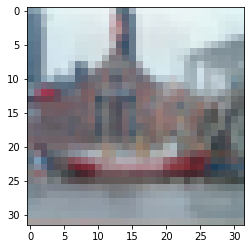

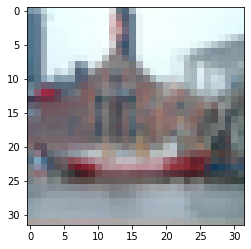

predicted ship
true ship
****************************************************************************************************


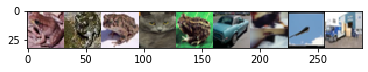

tensor([0.0018, 0.0087, 0.0044, 0.0268, 0.0085, 0.0073, 0.0066, 0.0049, 0.9310],
       device='cuda:0', dtype=torch.float64)


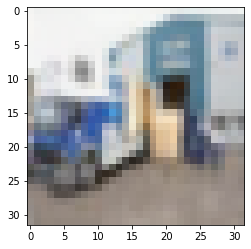

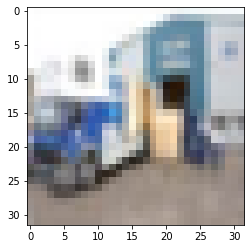

predicted truck
true truck
****************************************************************************************************


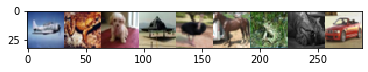

tensor([7.6327e-03, 5.1855e-05, 1.4721e-02, 3.6939e-02, 5.3100e-03, 9.1446e-01,
        4.6276e-04, 1.1708e-02, 8.7169e-03], device='cuda:0',
       dtype=torch.float64)


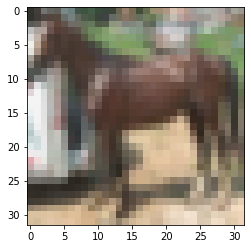

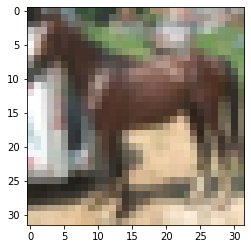

predicted horse
true horse
****************************************************************************************************


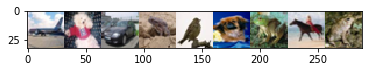

tensor([0.0328, 0.0108, 0.1018, 0.0293, 0.0029, 0.0239, 0.0719, 0.7213, 0.0053],
       device='cuda:0', dtype=torch.float64)


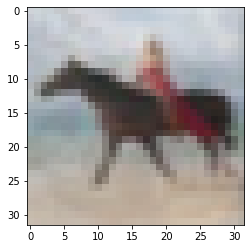

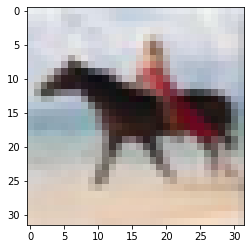

predicted horse
true horse
****************************************************************************************************


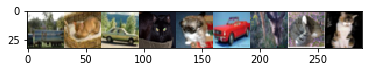

tensor([9.6124e-01, 4.6799e-03, 3.6919e-03, 1.1464e-02, 1.3918e-03, 6.4455e-03,
        5.4782e-03, 5.3856e-03, 2.2191e-04], device='cuda:0',
       dtype=torch.float64)


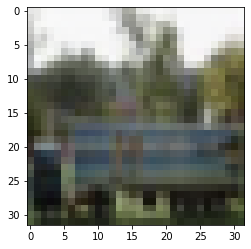

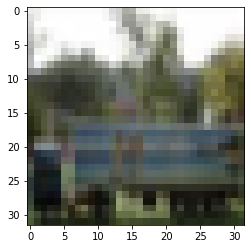

predicted truck
true truck
****************************************************************************************************


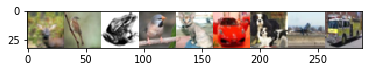

tensor([2.8086e-04, 2.4545e-03, 2.5235e-03, 1.7555e-03, 2.4198e-03, 8.8156e-04,
        1.0172e-03, 7.4146e-03, 9.8125e-01], device='cuda:0',
       dtype=torch.float64)


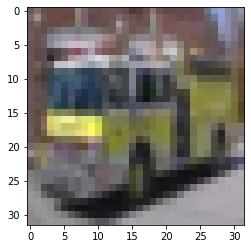

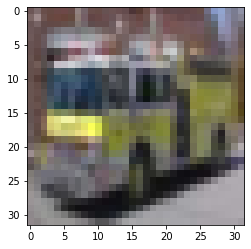

predicted truck
true truck
****************************************************************************************************


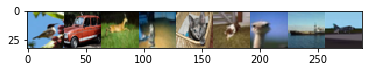

tensor([0.0043, 0.0097, 0.0018, 0.0095, 0.0088, 0.0089, 0.0137, 0.8305, 0.1127],
       device='cuda:0', dtype=torch.float64)


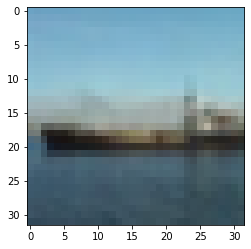

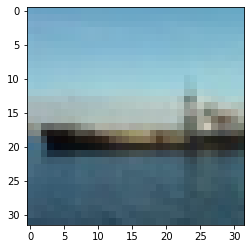

predicted ship
true ship
****************************************************************************************************


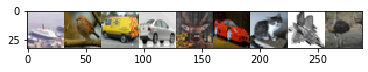

tensor([0.7155, 0.0233, 0.0210, 0.0205, 0.0875, 0.0429, 0.0158, 0.0470, 0.0264],
       device='cuda:0', dtype=torch.float64)


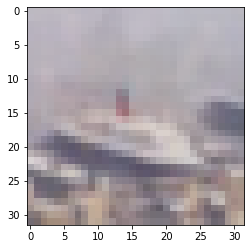

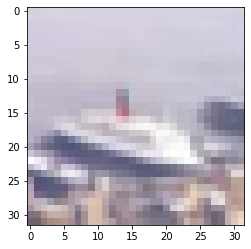

predicted ship
true ship
****************************************************************************************************


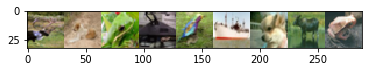

tensor([2.2612e-04, 2.3264e-03, 4.6948e-04, 5.1745e-03, 6.5261e-04, 9.5996e-01,
        4.4352e-03, 2.1570e-02, 5.1808e-03], device='cuda:0',
       dtype=torch.float64)


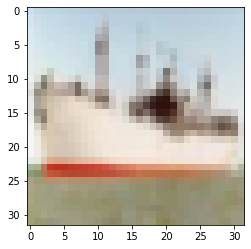

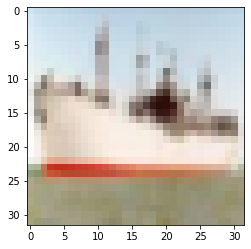

predicted ship
true ship
****************************************************************************************************


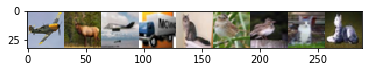

tensor([0.0070, 0.0159, 0.0084, 0.8504, 0.0113, 0.0132, 0.0415, 0.0127, 0.0396],
       device='cuda:0', dtype=torch.float64)


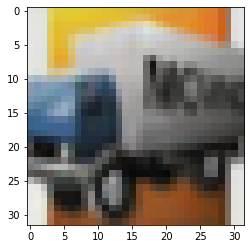

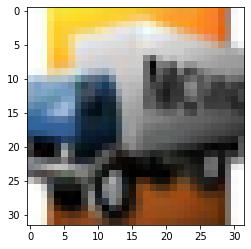

predicted truck
true truck
****************************************************************************************************


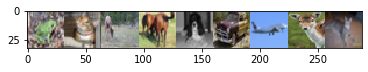

tensor([0.0835, 0.0255, 0.2178, 0.3717, 0.0346, 0.0960, 0.0143, 0.0434, 0.1131],
       device='cuda:0', dtype=torch.float64)


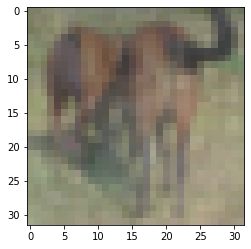

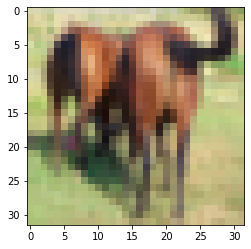

predicted horse
true horse
****************************************************************************************************


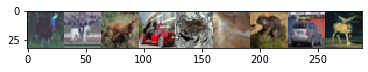

tensor([0.1084, 0.4386, 0.0533, 0.0303, 0.0475, 0.0318, 0.0304, 0.2547, 0.0051],
       device='cuda:0', dtype=torch.float64)


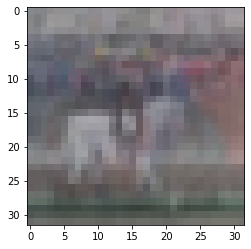

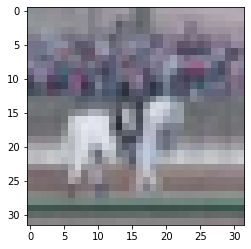

predicted horse
true horse
****************************************************************************************************


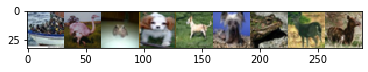

tensor([0.1110, 0.0762, 0.0136, 0.0492, 0.5035, 0.1069, 0.0705, 0.0075, 0.0615],
       device='cuda:0', dtype=torch.float64)


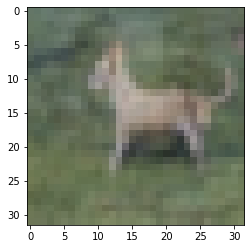

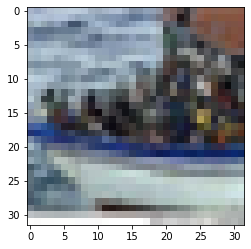

predicted ship
true ship
****************************************************************************************************


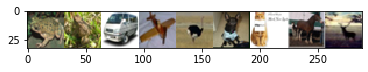

tensor([2.9859e-03, 1.3316e-04, 8.2913e-04, 2.8897e-03, 3.8456e-04, 5.1876e-04,
        2.4007e-03, 9.8874e-01, 1.1203e-03], device='cuda:0',
       dtype=torch.float64)


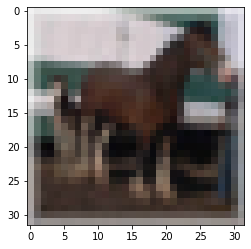

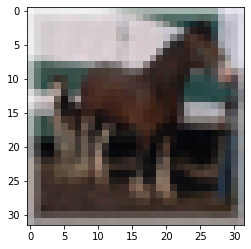

predicted horse
true horse
****************************************************************************************************


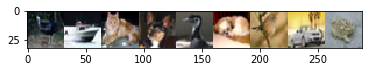

tensor([0.0592, 0.7198, 0.0068, 0.0032, 0.1446, 0.0099, 0.0016, 0.0232, 0.0317],
       device='cuda:0', dtype=torch.float64)


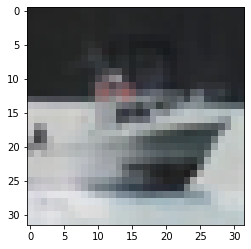

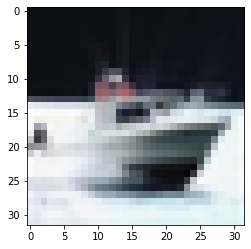

predicted ship
true ship
****************************************************************************************************


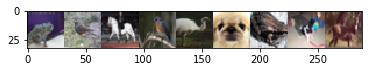

tensor([6.3410e-05, 1.7423e-04, 9.9892e-01, 1.8603e-04, 1.7372e-04, 3.6961e-05,
        1.8522e-04, 2.3211e-05, 2.3238e-04], device='cuda:0',
       dtype=torch.float64)


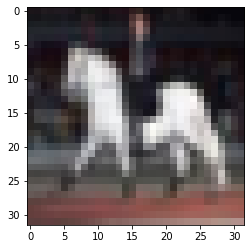

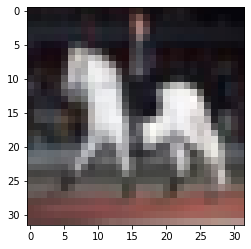

predicted horse
true horse
****************************************************************************************************


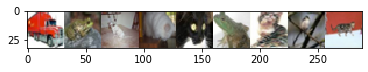

tensor([9.7730e-01, 3.2862e-03, 1.4508e-03, 7.4121e-03, 3.3465e-04, 1.5488e-03,
        7.7474e-03, 7.8866e-05, 8.4589e-04], device='cuda:0',
       dtype=torch.float64)


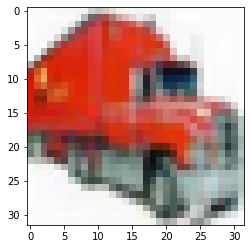

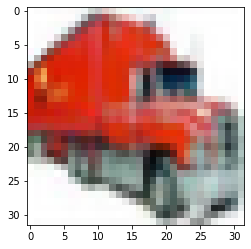

predicted truck
true truck
****************************************************************************************************


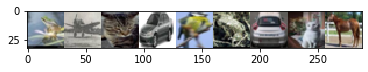

tensor([8.1111e-04, 3.6587e-03, 1.4872e-03, 2.4976e-03, 1.8973e-04, 2.0940e-04,
        2.6114e-03, 2.1419e-04, 9.8832e-01], device='cuda:0',
       dtype=torch.float64)


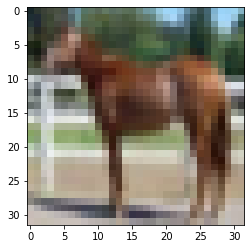

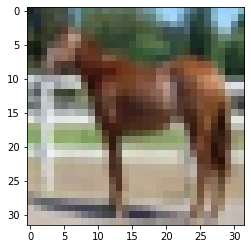

predicted horse
true horse
****************************************************************************************************


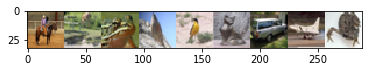

tensor([0.7001, 0.0123, 0.0063, 0.0273, 0.0203, 0.0816, 0.0327, 0.0512, 0.0682],
       device='cuda:0', dtype=torch.float64)


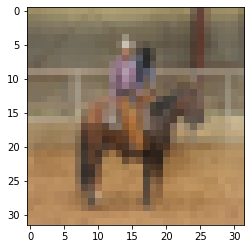

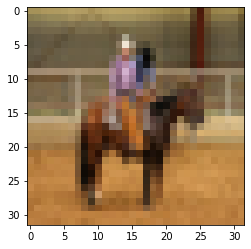

predicted horse
true horse
****************************************************************************************************


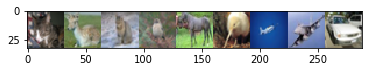

tensor([0.0068, 0.0120, 0.0289, 0.0324, 0.8446, 0.0153, 0.0137, 0.0144, 0.0318],
       device='cuda:0', dtype=torch.float64)


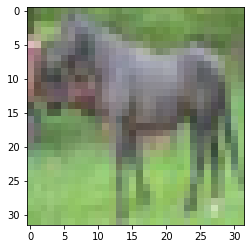

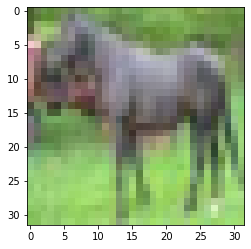

predicted horse
true horse
****************************************************************************************************


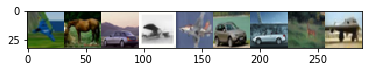

tensor([0.0278, 0.7588, 0.0163, 0.0015, 0.0184, 0.0151, 0.0804, 0.0325, 0.0491],
       device='cuda:0', dtype=torch.float64)


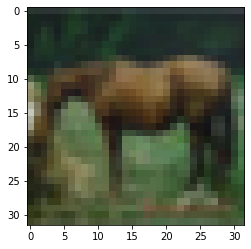

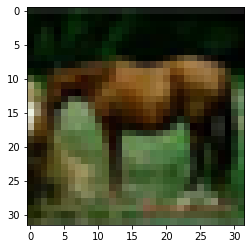

predicted horse
true horse
****************************************************************************************************


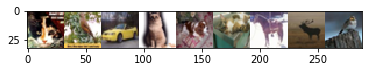

tensor([0.0058, 0.0475, 0.2081, 0.1494, 0.0494, 0.0694, 0.2009, 0.0973, 0.1722],
       device='cuda:0', dtype=torch.float64)


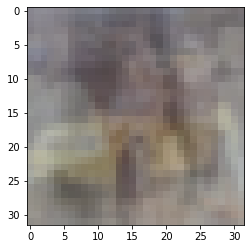

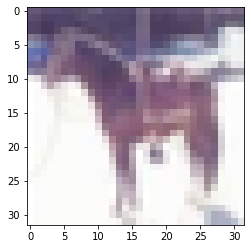

predicted horse
true horse
****************************************************************************************************


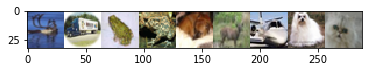

tensor([1.4872e-03, 9.9247e-01, 2.3701e-04, 4.2600e-05, 1.2899e-04, 1.4799e-03,
        1.3252e-03, 9.3842e-04, 1.8923e-03], device='cuda:0',
       dtype=torch.float64)


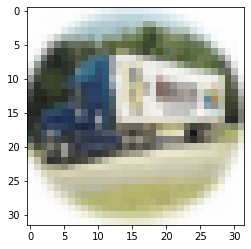

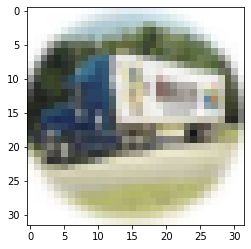

predicted truck
true truck
****************************************************************************************************


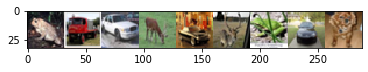

tensor([1.8324e-02, 9.5149e-01, 4.3989e-03, 7.7697e-03, 9.1642e-04, 9.7936e-03,
        2.4452e-03, 9.6067e-04, 3.9035e-03], device='cuda:0',
       dtype=torch.float64)


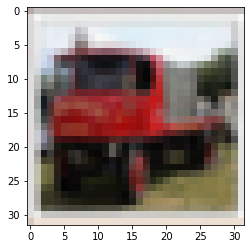

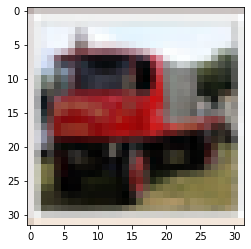

predicted truck
true truck
****************************************************************************************************


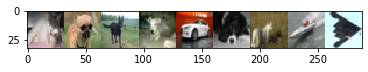

tensor([0.0197, 0.0179, 0.4464, 0.0501, 0.0153, 0.0311, 0.0183, 0.3802, 0.0209],
       device='cuda:0', dtype=torch.float64)


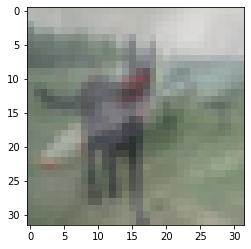

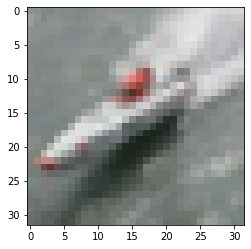

predicted ship
true ship
****************************************************************************************************


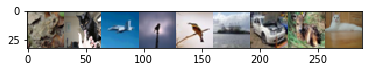

tensor([0.0392, 0.0135, 0.0175, 0.0199, 0.0023, 0.7678, 0.0564, 0.0433, 0.0401],
       device='cuda:0', dtype=torch.float64)


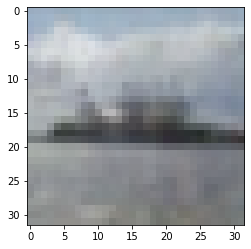

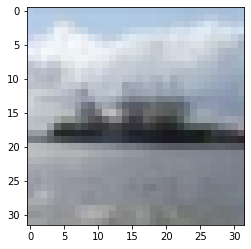

predicted ship
true ship
****************************************************************************************************


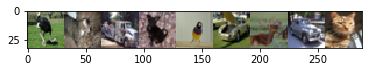

tensor([0.0342, 0.0214, 0.7888, 0.0052, 0.0150, 0.0114, 0.0419, 0.0769, 0.0051],
       device='cuda:0', dtype=torch.float64)


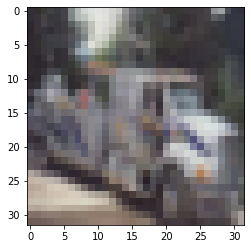

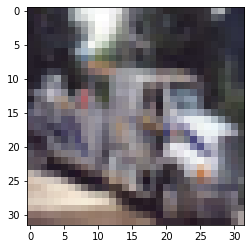

predicted truck
true truck
****************************************************************************************************


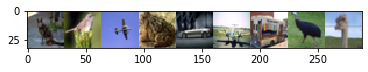

tensor([0.0092, 0.0171, 0.0026, 0.0165, 0.0293, 0.0130, 0.8993, 0.0018, 0.0111],
       device='cuda:0', dtype=torch.float64)


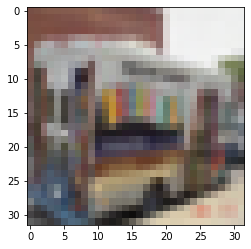

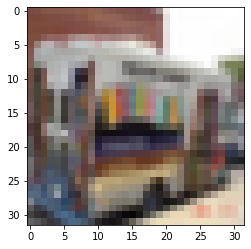

predicted truck
true truck
****************************************************************************************************


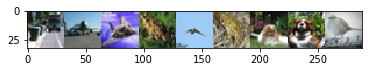

tensor([0.0770, 0.5049, 0.0220, 0.1561, 0.0104, 0.0082, 0.0919, 0.1082, 0.0212],
       device='cuda:0', dtype=torch.float64)


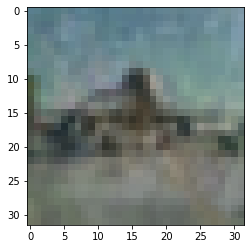

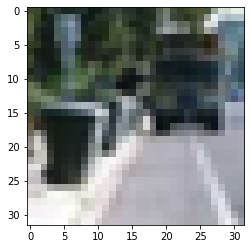

predicted truck
true truck
****************************************************************************************************


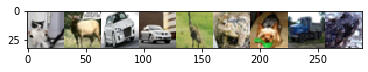

tensor([8.3625e-02, 2.0040e-03, 4.9464e-03, 2.1972e-02, 3.4693e-04, 1.9732e-02,
        3.2424e-03, 8.5777e-01, 6.3654e-03], device='cuda:0',
       dtype=torch.float64)


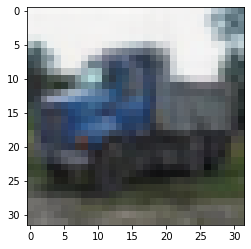

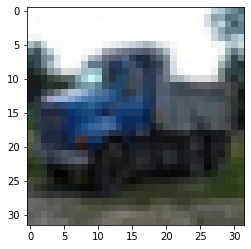

predicted truck
true truck
****************************************************************************************************


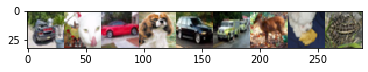

tensor([0.0226, 0.3040, 0.0279, 0.0103, 0.0272, 0.3869, 0.0493, 0.0287, 0.1431],
       device='cuda:0', dtype=torch.float64)


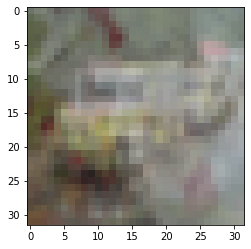

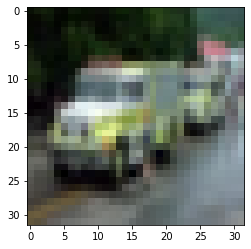

predicted truck
true truck
****************************************************************************************************


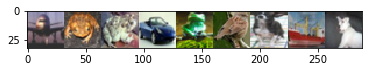

tensor([0.2130, 0.0085, 0.0261, 0.0224, 0.0023, 0.0143, 0.0145, 0.6921, 0.0070],
       device='cuda:0', dtype=torch.float64)


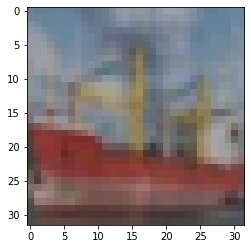

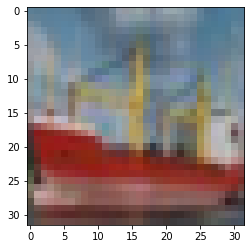

predicted ship
true ship
Accuracy of the network on the 30000 train images: 99 %
total correct 29901
total train set images 30000
focus_true_pred_true 46
focus_false_pred_true 4
focus_true_pred_false 0
focus_false_pred_false 0
argmax_more_than_half 41
argmax_less_than_half 9


In [32]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

train_loader1 = DataLoader( msd,batch_size= batch ,shuffle=False)
with torch.no_grad():
  for data in train_loader1:
    inputs, labels , fore_idx = data
    inputs,labels = inputs.to("cuda"),labels.to("cuda") 
    avg_images , alphas = where_net(inputs)
    outputs = what_net(avg_images)

    _, predicted = torch.max(outputs.data, 1)

    if flag==1 :
      for j in range (50):
        print("*"*100)
        img1 = torch.cat((inputs[j][0], inputs[j][1], inputs[j][2], inputs[j][3], inputs[j][4], inputs[j][5], inputs[j][6], inputs[j][7], inputs[j][8]) , 2)
        display(img1.cpu())

        print(alphas[j])

        img2 = avg_images[j]
        display(img2.cpu())

        img3 = inputs[j][fore_idx[j]]
        display(img3.cpu())

        print("predicted", classes[predicted[j]+7])
        print("true", classes[labels[j]+7])
        
        focus = torch.argmax(alphas[j])
      
        if(alphas[j][focus] >= 0.5):
          argmax_more_than_half +=1
        else:
          argmax_less_than_half +=1

        if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1

        elif(focus != fore_idx[j] and predicted[j] == labels[j]):
          focus_false_pred_true +=1

        elif(focus == fore_idx[j] and predicted[j] != labels[j]):
          focus_true_pred_false +=1

        elif(focus != fore_idx[j] and predicted[j] != labels[j]):
          focus_false_pred_false +=1

      flag =0

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true",focus_true_pred_true)
print("focus_false_pred_true",focus_false_pred_true )
print("focus_true_pred_false",focus_true_pred_false )
print("focus_false_pred_false",focus_false_pred_false)

print("argmax_more_than_half",argmax_more_than_half)
print("argmax_less_than_half",argmax_less_than_half)

In [0]:
test_images =[]        #list of mosaic images, each mosaic image is saved as laist of 9 images
fore_idx_test =[]                   #list of indexes at which foreground image is present in a mosaic image                
test_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(10000):
    bg_idx = np.random.randint(0,35000,8)
    fg_idx = np.random.randint(0,15000)
    fg = np.random.randint(0,9)
    fore_idx_test.append(fg)
    image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
    test_images.append(image_list)
    test_label.append(label)

In [0]:
# test_data = MosaicDataset(test_images,test_label,)
# test_loader = DataLoader( test_data,batch_size= batch ,shuffle=False)

2


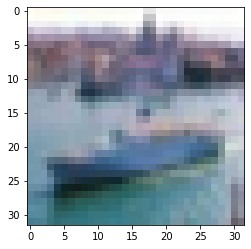

ship


In [35]:
print(fore_idx_test[0])
imshow(test_images[0][fore_idx_test[0]])
print(classes[test_label[0]+7])

****************************************************************************************************


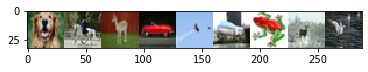

tensor([0.0416, 0.2727, 0.2153, 0.0674, 0.0164, 0.1507, 0.0037, 0.0770, 0.1553],
       device='cuda:0', dtype=torch.float64)


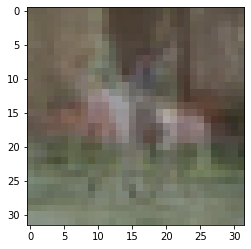

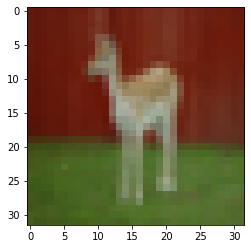

predicted horse
true horse
****************************************************************************************************


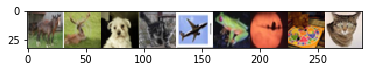

tensor([7.7247e-01, 7.8879e-03, 9.1658e-03, 1.6349e-01, 7.1029e-04, 2.9414e-02,
        1.4869e-03, 6.5280e-03, 8.8522e-03], device='cuda:0',
       dtype=torch.float64)


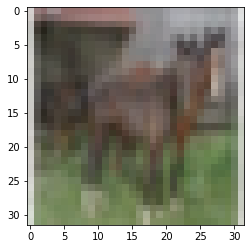

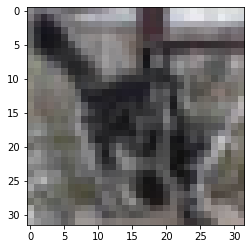

predicted horse
true horse
****************************************************************************************************


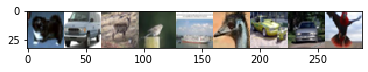

tensor([0.0084, 0.0140, 0.0292, 0.0202, 0.7584, 0.0611, 0.0038, 0.1027, 0.0021],
       device='cuda:0', dtype=torch.float64)


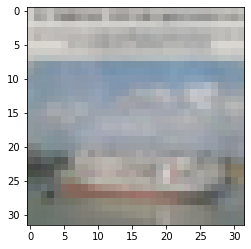

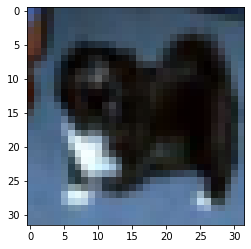

predicted ship
true ship
****************************************************************************************************


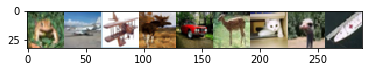

tensor([0.0078, 0.0224, 0.0173, 0.0134, 0.3990, 0.0755, 0.0207, 0.0455, 0.3984],
       device='cuda:0', dtype=torch.float64)


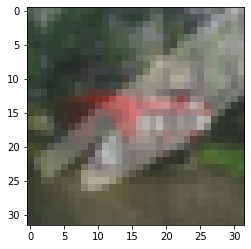

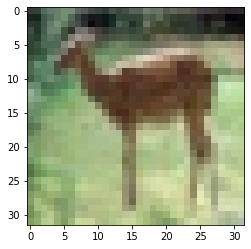

predicted ship
true ship
****************************************************************************************************


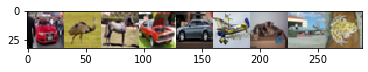

tensor([1.7152e-03, 2.0623e-04, 9.8628e-01, 2.0322e-03, 1.8554e-03, 2.8221e-04,
        4.9950e-03, 2.3608e-03, 2.7642e-04], device='cuda:0',
       dtype=torch.float64)


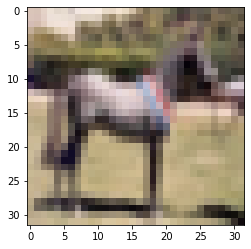

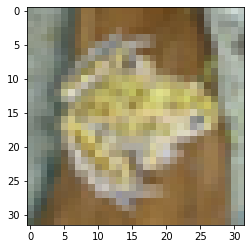

predicted horse
true horse
****************************************************************************************************


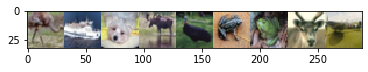

tensor([0.0672, 0.7331, 0.0325, 0.0354, 0.0576, 0.0093, 0.0387, 0.0050, 0.0212],
       device='cuda:0', dtype=torch.float64)


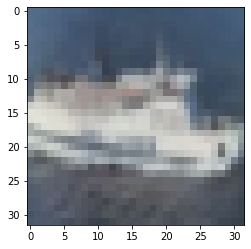

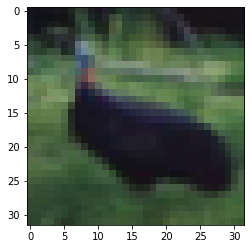

predicted ship
true ship
****************************************************************************************************


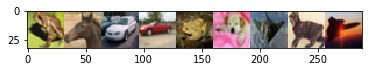

tensor([0.0236, 0.0399, 0.0305, 0.6130, 0.0395, 0.0023, 0.0076, 0.1614, 0.0823],
       device='cuda:0', dtype=torch.float64)


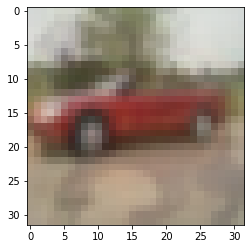

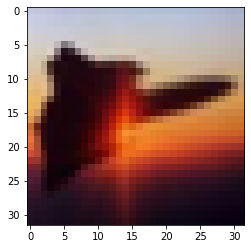

predicted truck
true horse
****************************************************************************************************


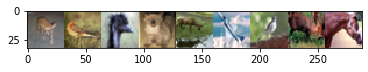

tensor([0.1959, 0.0790, 0.1816, 0.0408, 0.1139, 0.1325, 0.1458, 0.0688, 0.0416],
       device='cuda:0', dtype=torch.float64)


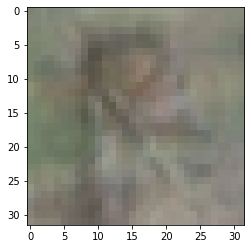

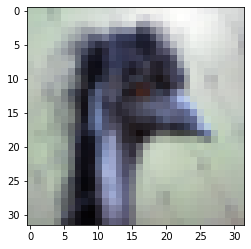

predicted ship
true horse
****************************************************************************************************


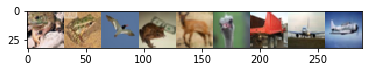

tensor([0.0015, 0.0020, 0.0073, 0.0068, 0.0022, 0.0210, 0.9237, 0.0229, 0.0127],
       device='cuda:0', dtype=torch.float64)


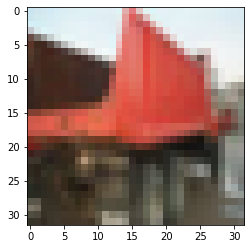

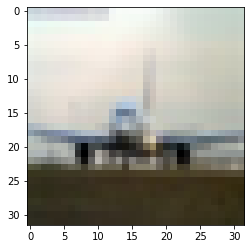

predicted truck
true truck
****************************************************************************************************


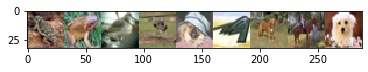

tensor([3.7334e-03, 9.7272e-03, 5.7351e-03, 9.5915e-03, 1.6752e-03, 3.6705e-03,
        1.3564e-02, 9.5222e-01, 8.7366e-05], device='cuda:0',
       dtype=torch.float64)


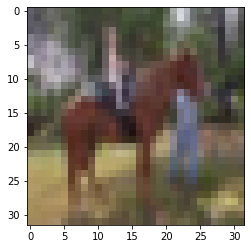

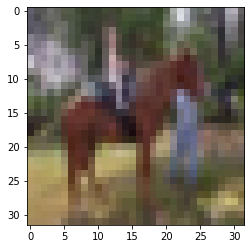

predicted horse
true horse
****************************************************************************************************


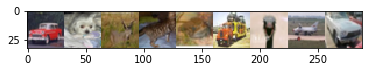

tensor([2.7807e-02, 6.9882e-03, 2.3977e-02, 4.2824e-02, 1.6589e-02, 3.8534e-01,
        4.2062e-04, 4.8096e-01, 1.5093e-02], device='cuda:0',
       dtype=torch.float64)


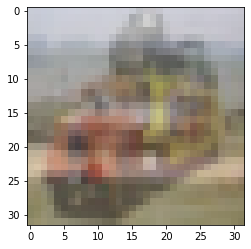

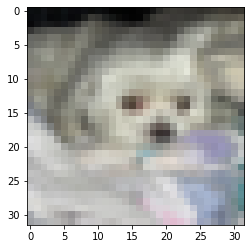

predicted truck
true truck
****************************************************************************************************


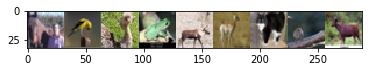

tensor([0.2958, 0.0359, 0.0925, 0.0821, 0.0619, 0.1170, 0.0948, 0.2080, 0.0122],
       device='cuda:0', dtype=torch.float64)


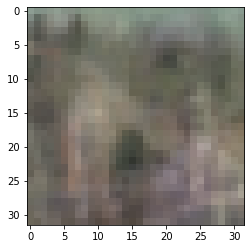

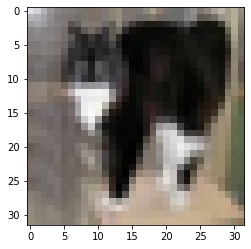

predicted horse
true horse
****************************************************************************************************


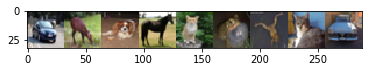

tensor([4.6500e-06, 1.1713e-06, 7.0571e-06, 9.9990e-01, 4.9750e-06, 1.8550e-05,
        2.5202e-05, 2.2018e-05, 1.3594e-05], device='cuda:0',
       dtype=torch.float64)


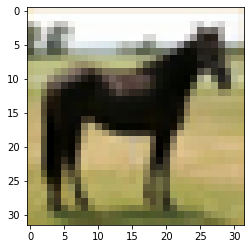

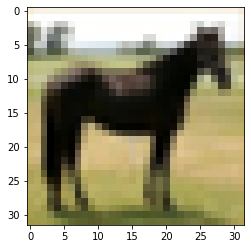

predicted horse
true horse
****************************************************************************************************


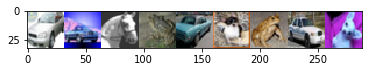

tensor([0.0784, 0.1271, 0.0826, 0.1965, 0.0737, 0.0364, 0.0298, 0.2684, 0.1071],
       device='cuda:0', dtype=torch.float64)


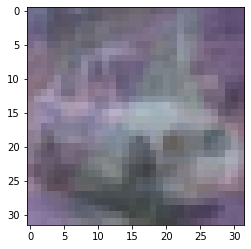

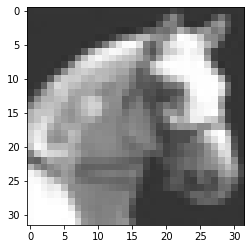

predicted ship
true horse
****************************************************************************************************


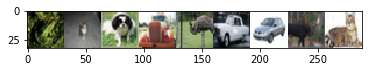

tensor([0.0080, 0.1235, 0.0035, 0.3539, 0.2204, 0.0238, 0.0099, 0.0686, 0.1884],
       device='cuda:0', dtype=torch.float64)


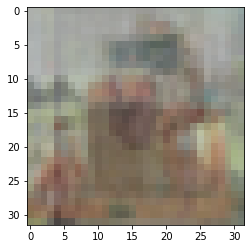

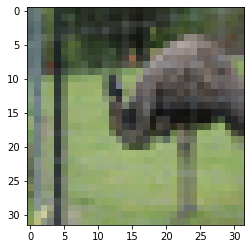

predicted horse
true truck
****************************************************************************************************


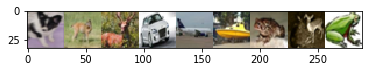

tensor([0.0560, 0.0533, 0.0394, 0.0586, 0.1865, 0.0442, 0.1740, 0.3849, 0.0031],
       device='cuda:0', dtype=torch.float64)


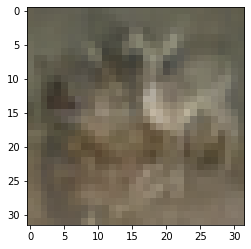

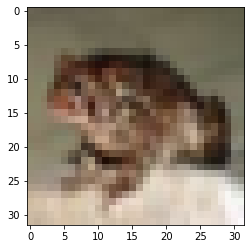

predicted horse
true ship
****************************************************************************************************


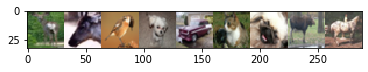

tensor([0.0987, 0.0673, 0.0038, 0.0388, 0.0186, 0.1151, 0.0378, 0.0328, 0.5872],
       device='cuda:0', dtype=torch.float64)


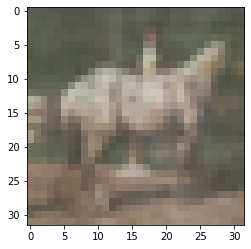

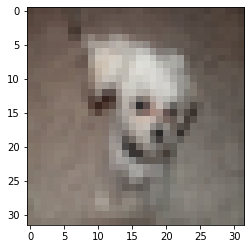

predicted horse
true horse
****************************************************************************************************


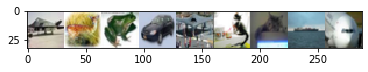

tensor([0.0277, 0.0093, 0.0018, 0.0184, 0.1036, 0.0207, 0.0254, 0.7542, 0.0388],
       device='cuda:0', dtype=torch.float64)


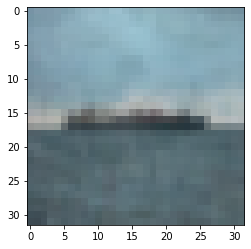

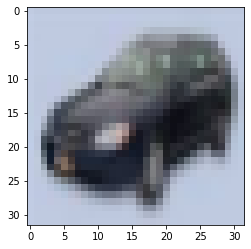

predicted ship
true ship
****************************************************************************************************


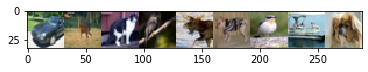

tensor([0.0044, 0.0339, 0.0149, 0.0058, 0.0075, 0.0168, 0.0345, 0.7672, 0.1149],
       device='cuda:0', dtype=torch.float64)


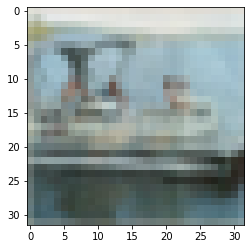

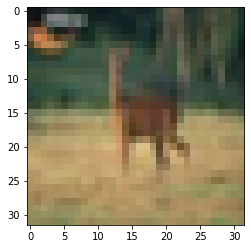

predicted ship
true ship
****************************************************************************************************


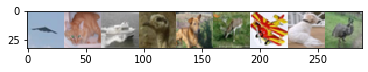

tensor([0.0237, 0.0249, 0.7138, 0.0336, 0.0895, 0.0510, 0.0017, 0.0394, 0.0223],
       device='cuda:0', dtype=torch.float64)


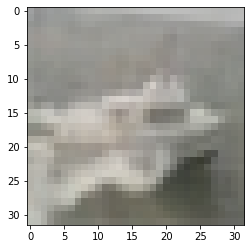

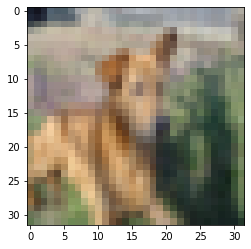

predicted ship
true ship
****************************************************************************************************


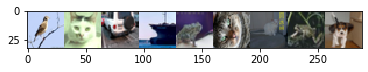

tensor([0.0034, 0.0815, 0.1702, 0.1601, 0.0262, 0.1284, 0.2970, 0.0679, 0.0655],
       device='cuda:0', dtype=torch.float64)


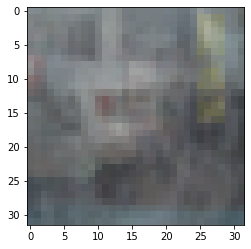

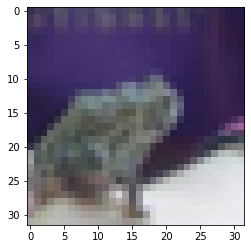

predicted ship
true ship
****************************************************************************************************


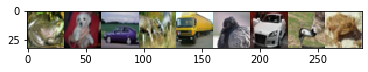

tensor([0.0218, 0.0035, 0.2380, 0.0151, 0.6462, 0.0240, 0.0267, 0.0046, 0.0200],
       device='cuda:0', dtype=torch.float64)


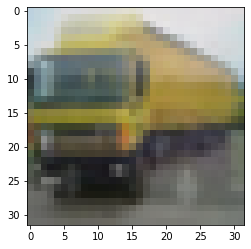

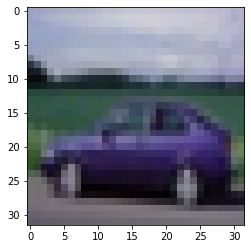

predicted truck
true truck
****************************************************************************************************


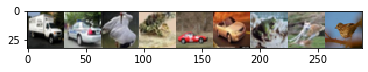

tensor([0.7646, 0.0053, 0.0304, 0.0062, 0.0283, 0.0055, 0.1374, 0.0038, 0.0185],
       device='cuda:0', dtype=torch.float64)


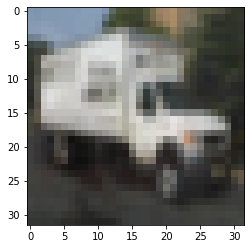

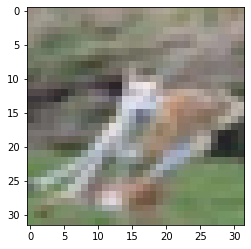

predicted truck
true truck
****************************************************************************************************


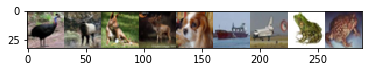

tensor([1.7276e-04, 3.1671e-04, 1.1641e-04, 1.0002e-03, 4.8027e-04, 9.9366e-01,
        2.8179e-03, 3.7209e-04, 1.0591e-03], device='cuda:0',
       dtype=torch.float64)


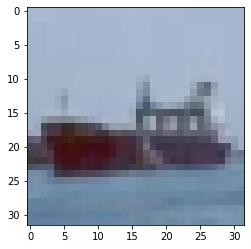

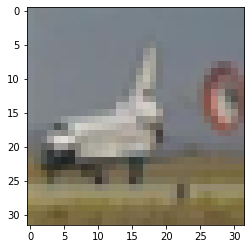

predicted ship
true ship
****************************************************************************************************


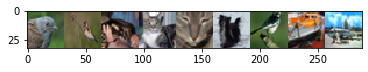

tensor([0.1348, 0.2827, 0.1588, 0.0954, 0.0394, 0.0450, 0.1516, 0.0392, 0.0530],
       device='cuda:0', dtype=torch.float64)


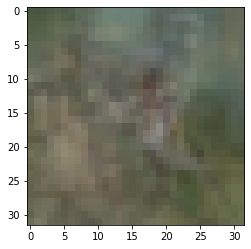

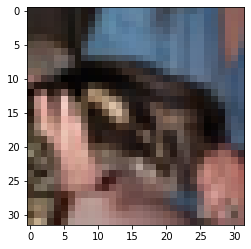

predicted horse
true ship
****************************************************************************************************


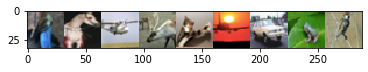

tensor([0.0114, 0.0014, 0.1038, 0.0778, 0.2128, 0.0203, 0.5103, 0.0394, 0.0227],
       device='cuda:0', dtype=torch.float64)


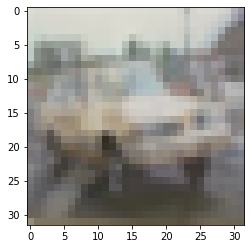

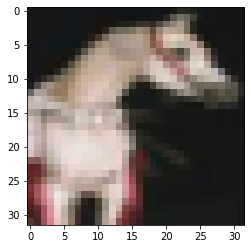

predicted truck
true horse
****************************************************************************************************


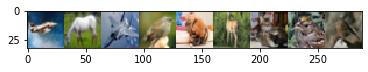

tensor([0.0190, 0.6444, 0.0788, 0.0063, 0.0212, 0.1018, 0.0336, 0.0560, 0.0387],
       device='cuda:0', dtype=torch.float64)


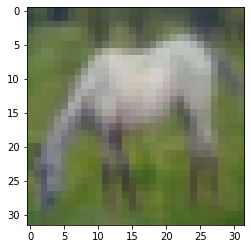

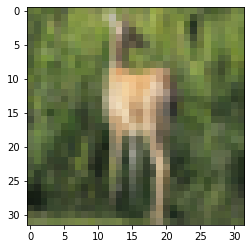

predicted horse
true horse
****************************************************************************************************


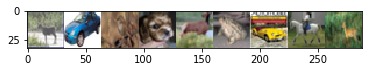

tensor([0.0132, 0.0030, 0.0318, 0.0150, 0.0944, 0.0285, 0.0579, 0.6952, 0.0610],
       device='cuda:0', dtype=torch.float64)


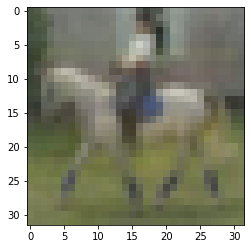

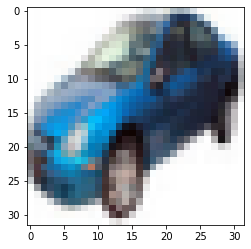

predicted horse
true horse
****************************************************************************************************


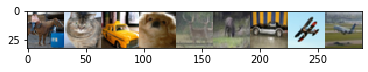

tensor([6.9479e-01, 3.1885e-02, 5.9035e-03, 1.4677e-02, 8.4115e-02, 3.6431e-02,
        4.1700e-02, 1.5975e-04, 9.0337e-02], device='cuda:0',
       dtype=torch.float64)


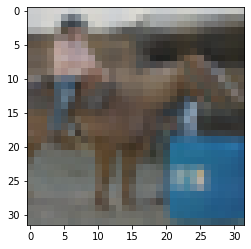

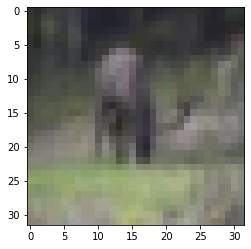

predicted horse
true horse
****************************************************************************************************


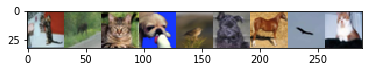

tensor([0.0076, 0.0864, 0.0661, 0.0027, 0.1430, 0.1336, 0.4052, 0.0882, 0.0672],
       device='cuda:0', dtype=torch.float64)


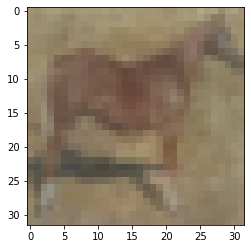

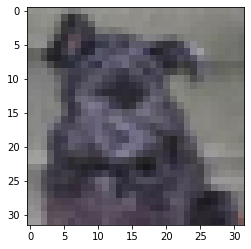

predicted horse
true horse
****************************************************************************************************


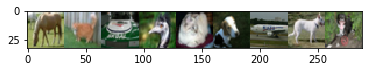

tensor([0.4929, 0.1029, 0.1034, 0.0312, 0.0285, 0.0408, 0.0903, 0.0709, 0.0392],
       device='cuda:0', dtype=torch.float64)


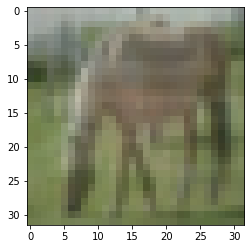

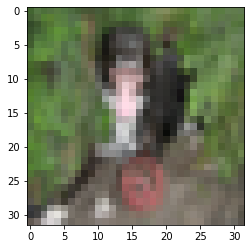

predicted horse
true horse
****************************************************************************************************


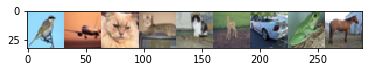

tensor([2.1191e-05, 1.2789e-05, 4.8565e-05, 4.5622e-04, 2.3524e-03, 5.8628e-04,
        6.2856e-04, 3.4384e-04, 9.9555e-01], device='cuda:0',
       dtype=torch.float64)


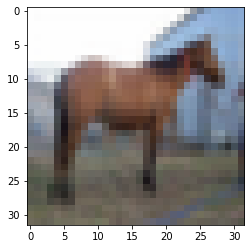

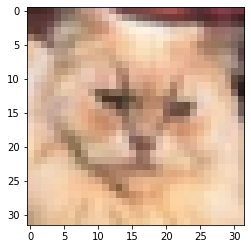

predicted horse
true horse
****************************************************************************************************


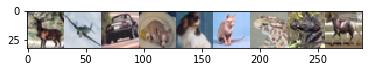

tensor([0.0088, 0.0036, 0.1528, 0.0096, 0.0135, 0.0193, 0.0177, 0.0120, 0.7628],
       device='cuda:0', dtype=torch.float64)


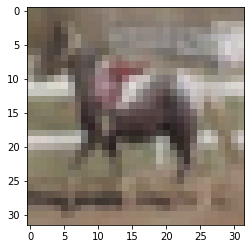

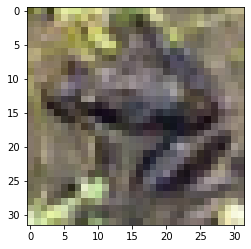

predicted horse
true horse
****************************************************************************************************


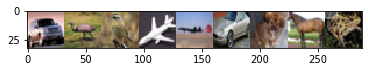

tensor([0.0027, 0.0096, 0.0202, 0.0035, 0.0490, 0.0389, 0.0280, 0.8387, 0.0094],
       device='cuda:0', dtype=torch.float64)


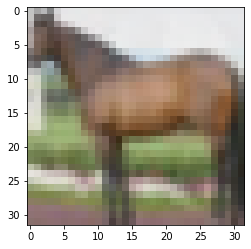

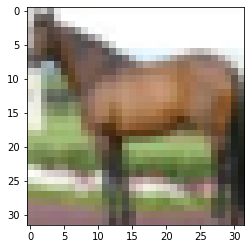

predicted horse
true horse
****************************************************************************************************


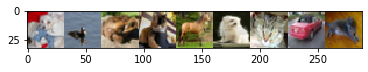

tensor([0.0182, 0.0636, 0.0857, 0.0393, 0.5968, 0.0266, 0.0347, 0.0916, 0.0434],
       device='cuda:0', dtype=torch.float64)


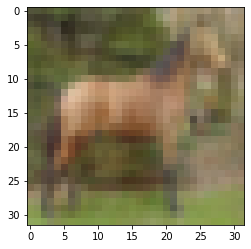

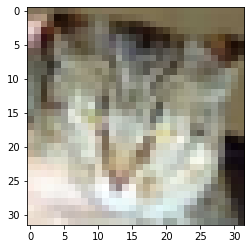

predicted horse
true horse
****************************************************************************************************


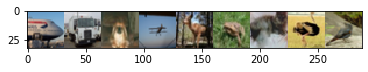

tensor([0.2053, 0.6992, 0.0064, 0.0081, 0.0400, 0.0064, 0.0286, 0.0025, 0.0035],
       device='cuda:0', dtype=torch.float64)


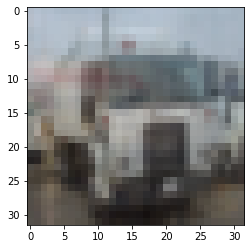

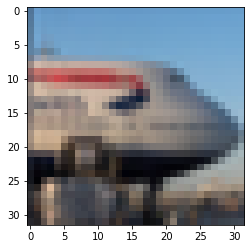

predicted truck
true truck
****************************************************************************************************


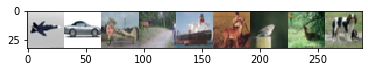

tensor([0.0081, 0.0202, 0.5608, 0.0547, 0.1853, 0.0881, 0.0352, 0.0026, 0.0450],
       device='cuda:0', dtype=torch.float64)


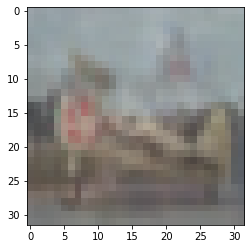

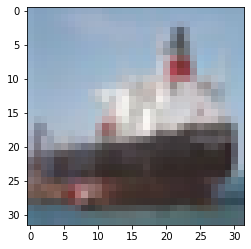

predicted ship
true ship
****************************************************************************************************


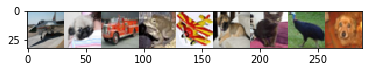

tensor([0.0355, 0.0029, 0.8139, 0.0265, 0.0013, 0.0151, 0.1007, 0.0024, 0.0016],
       device='cuda:0', dtype=torch.float64)


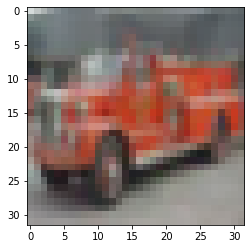

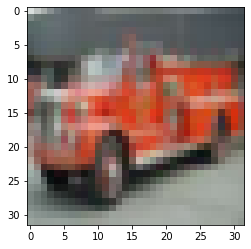

predicted truck
true truck
****************************************************************************************************


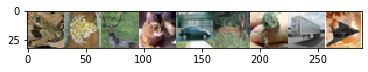

tensor([3.9610e-04, 5.3226e-04, 8.2169e-04, 3.3136e-03, 1.4584e-03, 2.1042e-03,
        1.5055e-03, 9.8974e-01, 1.3118e-04], device='cuda:0',
       dtype=torch.float64)


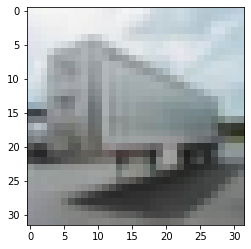

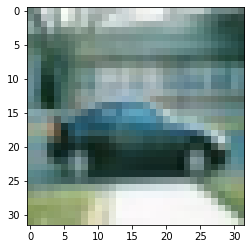

predicted ship
true truck
****************************************************************************************************


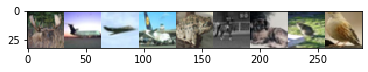

tensor([0.0488, 0.3729, 0.0070, 0.1087, 0.0965, 0.2310, 0.1071, 0.0065, 0.0215],
       device='cuda:0', dtype=torch.float64)


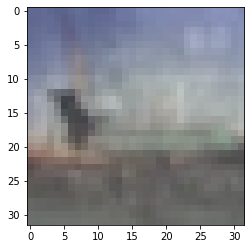

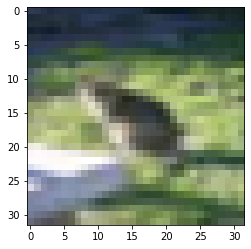

predicted horse
true horse
****************************************************************************************************


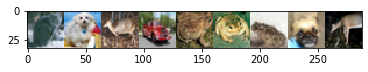

tensor([0.0150, 0.0030, 0.0146, 0.8078, 0.0052, 0.0081, 0.1031, 0.0051, 0.0381],
       device='cuda:0', dtype=torch.float64)


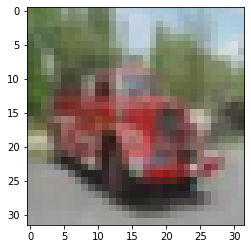

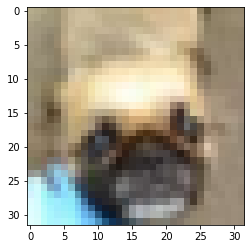

predicted truck
true truck
****************************************************************************************************


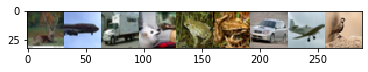

tensor([0.0260, 0.0228, 0.8988, 0.0208, 0.0051, 0.0059, 0.0101, 0.0025, 0.0078],
       device='cuda:0', dtype=torch.float64)


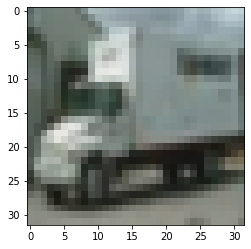

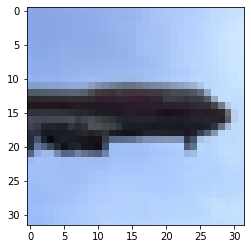

predicted truck
true truck
****************************************************************************************************


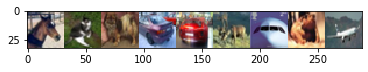

tensor([0.5189, 0.0237, 0.0407, 0.0527, 0.0958, 0.0421, 0.1627, 0.0098, 0.0536],
       device='cuda:0', dtype=torch.float64)


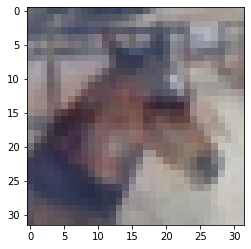

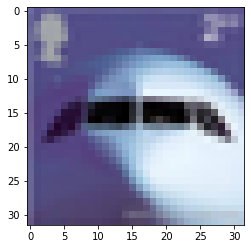

predicted horse
true horse
****************************************************************************************************


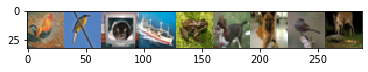

tensor([0.0238, 0.0051, 0.0146, 0.8311, 0.0034, 0.0095, 0.0583, 0.0198, 0.0345],
       device='cuda:0', dtype=torch.float64)


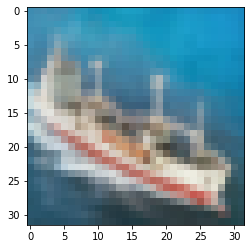

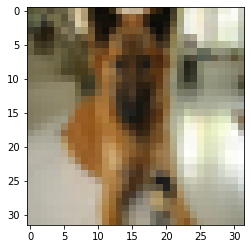

predicted ship
true ship
****************************************************************************************************


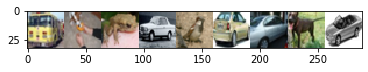

tensor([0.8836, 0.0138, 0.0187, 0.0091, 0.0115, 0.0181, 0.0127, 0.0312, 0.0014],
       device='cuda:0', dtype=torch.float64)


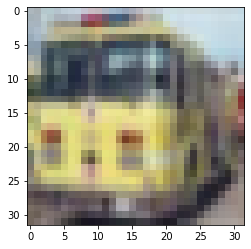

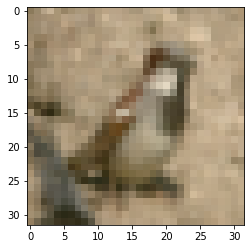

predicted truck
true truck
****************************************************************************************************


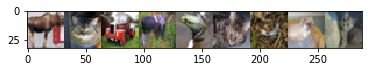

tensor([6.6421e-03, 1.4896e-02, 9.0151e-01, 1.9073e-02, 3.6912e-04, 2.9535e-02,
        1.0529e-02, 7.9439e-03, 9.5067e-03], device='cuda:0',
       dtype=torch.float64)


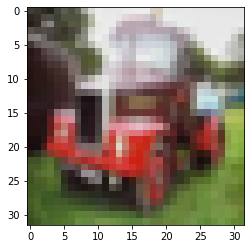

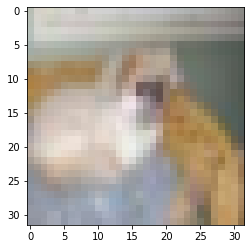

predicted truck
true truck
****************************************************************************************************


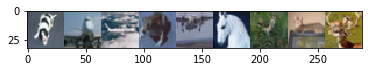

tensor([0.0083, 0.7490, 0.0532, 0.0260, 0.0663, 0.0073, 0.0534, 0.0332, 0.0032],
       device='cuda:0', dtype=torch.float64)


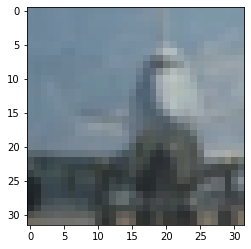

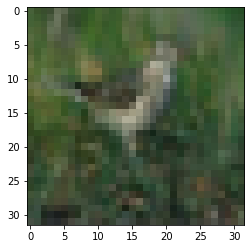

predicted horse
true horse
****************************************************************************************************


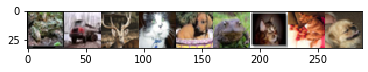

tensor([0.0094, 0.8756, 0.0261, 0.0093, 0.0174, 0.0234, 0.0266, 0.0080, 0.0041],
       device='cuda:0', dtype=torch.float64)


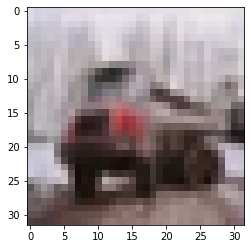

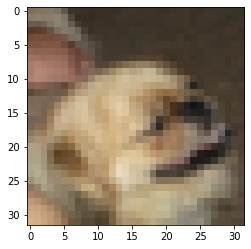

predicted truck
true truck
****************************************************************************************************


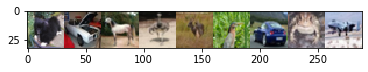

tensor([0.0379, 0.1358, 0.1851, 0.1077, 0.0611, 0.0213, 0.1311, 0.3045, 0.0156],
       device='cuda:0', dtype=torch.float64)


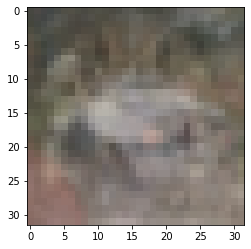

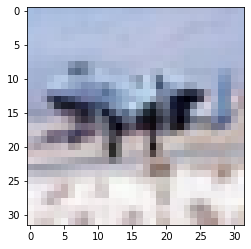

predicted ship
true horse
****************************************************************************************************


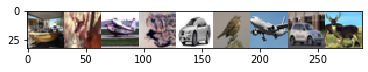

tensor([0.1572, 0.0325, 0.1924, 0.1243, 0.0135, 0.0266, 0.0422, 0.1959, 0.2154],
       device='cuda:0', dtype=torch.float64)


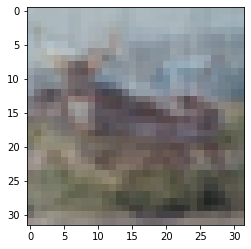

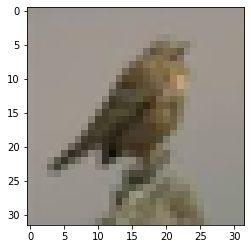

predicted ship
true ship
Accuracy of the network on the 10000 test images: 82 %
total correct 8242
total test set images 10000


In [36]:
correct = 0
total = 0
flag =1
with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs,labels = inputs.to("cuda"),labels.to("cuda") 
    avg_images , alphas = where_net(inputs)
    outputs = what_net(avg_images)
    _, predicted = torch.max(outputs.data, 1)


    if flag==1 :
      for j in range (50):
        print("*"*100)
        img1 = torch.cat((inputs[j][0], inputs[j][1], inputs[j][2], inputs[j][3], inputs[j][4], inputs[j][5], inputs[j][6], inputs[j][7], inputs[j][8]) , 2)
        display(img1.cpu())

        print(alphas[j])

        img2 = avg_images[j]
        display(img2.cpu())

        img3 = inputs[j][fore_idx_test[j]]
        display(img3.cpu())

        print("predicted", classes[predicted[j]+7])
        print("true", classes[labels[j]+7])

      flag =0


    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
print("total correct", correct)
print("total test set images", total)

In [0]:
a = torch.tensor([0.0071, 0.0466, 0.0025, 0.0282, 0.0140, 0.0067, 0.0145, 0.8750, 0.0055])

In [38]:
print(torch.argmax(a) == 7)
print(batch)

tensor(True)
250


In [39]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

train_loader1 = DataLoader( msd,batch_size= batch ,shuffle=False)
with torch.no_grad():
  for data in train_loader1:
    inputs, labels , fore_idx = data
    inputs,labels = inputs.to("cuda"),labels.to("cuda") 
    avg_images , alphas = where_net(inputs)
    outputs = what_net(avg_images)
    _, predicted = torch.max(outputs.data, 1)
    
    for j in range (batch):
      focus = torch.argmax(alphas[j])
      
      if(alphas[j][focus] >= 0.5):
        argmax_more_than_half +=1
      else:
        argmax_less_than_half +=1
        
      if(focus == fore_idx[j] and predicted[j] == labels[j]):
        focus_true_pred_true += 1
        
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true +=1
        
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false +=1
        
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false +=1
      
#       print("*"*100)
#       img1 = torch.cat((inputs[j][0], inputs[j][1], inputs[j][2], inputs[j][3], inputs[j][4], inputs[j][5], inputs[j][6], inputs[j][7], inputs[j][8]) , 2)
#       display(img1)

#       print(alphas[j])

#       img2 = avg_images[j]
#       display(img2)

#       img3 = inputs[j][fore_idx[j]]
#       display(img3)

#       print("predicted", classes[predicted[j]+7])
#       print("true", classes[labels[j]+7])

     
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true",focus_true_pred_true)
print("focus_false_pred_true",focus_false_pred_true )
print("focus_true_pred_false",focus_true_pred_false )
print("focus_false_pred_false",focus_false_pred_false)

print("argmax_more_than_half",argmax_more_than_half)
print("argmax_less_than_half",argmax_less_than_half)

Accuracy of the network on the 30000 train images: 99 %
total correct 29901
total train set images 30000
focus_true_pred_true 24206
focus_false_pred_true 5695
focus_true_pred_false 15
focus_false_pred_false 84
argmax_more_than_half 22094
argmax_less_than_half 7906


In [40]:
bg_idx = np.random.randint(0,35000,8)
fg_idx = np.random.randint(0,15000)
fg = np.random.randint(0,9)
fore_idx_test.append(fg)
image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
test_images.append(image_list)
test_label.append(label)
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs,labels = inputs.to("cuda"),labels.to("cuda") 
    avg_images , alphas = where_net(inputs)
    outputs = what_net(avg_images)

    _, predicted = torch.max(outputs.data, 1)
    
    for j in range (batch):
      focus = torch.argmax(alphas[j])
      
      if(alphas[j][focus] >= 0.5):
        argmax_more_than_half +=1
      else:
        argmax_less_than_half +=1
        
      if(focus == fore_idx[j] and predicted[j] == labels[j]):
        focus_true_pred_true += 1
        
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true +=1
        
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false +=1
        
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false +=1
      
#       print("*"*100)
#       img1 = torch.cat((inputs[j][0], inputs[j][1], inputs[j][2], inputs[j][3], inputs[j][4], inputs[j][5], inputs[j][6], inputs[j][7], inputs[j][8]) , 2)
#       display(img1)

#       print(alphas[j])

#       img2 = avg_images[j]
#       display(img2)

#       img3 = inputs[j][fore_idx[j]]
#       display(img3)

#       print("predicted", classes[predicted[j]+7])
#       print("true", classes[labels[j]+7])

     
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true",focus_true_pred_true)
print("focus_false_pred_true",focus_false_pred_true )
print("focus_true_pred_false",focus_true_pred_false )
print("focus_false_pred_false",focus_false_pred_false)

print("argmax_more_than_half",argmax_more_than_half)
print("argmax_less_than_half",argmax_less_than_half)

Accuracy of the network on the 30000 train images: 82 %
total correct 8242
total train set images 10000
focus_true_pred_true 7122
focus_false_pred_true 1120
focus_true_pred_false 473
focus_false_pred_false 1285
argmax_more_than_half 6928
argmax_less_than_half 3072


In [0]:
# epoch = 100
# for i in range(epoch):
#   if (i %40) <20:
#     print("What",i)
#   elif (i%40)>20:
#     print("Where",i)